In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import spearmanr, linregress, pearsonr
from ipypublish import nb_setup
from IPython.display import display, HTML, Markdown
import pandas as pd

In [ ]:
sns.set()
sns.set_context("talk")

In [ ]:
modelos, serie_vulnerabilidad = calcular_periodo_vulnerabilidad('20-04-24', '20-07-15')

In [ ]:
serie_vulnerabilidad = agregar_vulnerabilidad_entidades(serie_vulnerabilidad, 'valor')

In [ ]:
checkpoint_vulnerabilidad(serie_vulnerabilidad, 'prueba.feather')

In [ ]:
guardar_shape_vulnerabilidad(serie_vulnerabilidad, 'vulnerabilidad_pls_20-07-14.shp', '20-07-14')

In [ ]:
table = serie_vulnerabilidad.drop(columns='geometry').head()
display(Markdown(table.to_markdown(showindex=False)))

In [ ]:
mapas_serie_letalidad(serie_vulnerabilidad, lapso_dias=1)
mapas_serie_vulnerabilidad(serie_vulnerabilidad, lapso_dias=1)

In [ ]:
diccionario_indicadores_old = pd.read_csv('datos/variablesf.csv', encoding='latin-1', index_col=False)
diccionario_indicadores = pd.read_csv('datos/diccionario_vulnerabilidad.csv', encoding='UTF-8', index_col=False)

faltantes = diccionario_indicadores_old.loc[diccionario_indicadores_old.Variable.isin(list(set(diccionario_indicadores_old.Variable).difference(diccionario_indicadores.campo)))].copy()

faltantes.sort_values(by='Variable', inplace=True)
faltantes.rename(columns={'Variable': 'campo', 'Descripción': 'descriptor'}, inplace=True)

caracteristicas_indice = caracteristicas_modelos_municipios(serie_vulnerabilidad, poblaciones=False, i_vuln=False)
caracteristicas_indice

diccionario_indicadores = diccionario_indicadores.loc[diccionario_indicadores.campo.isin(caracteristicas_indice),:].sort_values(by='campo')

# Objetivo

Identificar municipios vulnerables ante la amenaza de COVID-19, donde entendemos vulnerabilidad como mayor suceptibilidad a padecer efectos adversos por la enfermedad, y entender qué características están más ligadas a esta vulnerabilidad. 

La vulnerabilidad de una población la evaluamos con base en sus características de desarrollo social, economía, y salubridad. El índice de vulnerabilidad produce: un mapa de vulnerabilidad municipal, un ordenamiento de los municipios de México de acuerdo con el riesgo que representa para sus habitantes la exposición al Sars-Cov-2, y una relación de los indicadores y la letalidad de COVID-19. Un objetivo particular es tener una evaluación preliminar sobre el riesgo potencial para municipios donde todavía no se han reportado casos. 

# Definiciones

**Amenaza**
: 'La potencial ocurrencia de eventos físicos de origen natural o antropogénico que pueden tener efectos adversos sobre los elementos vulnerables y expuestos', [^diaz_cervantes]

**Exposición**
: 'la intensidad y duración en que los elementos, como personas, ecosistemas, infraestructura y servicios, están presentes en lugares que podrían verse afectados negativamente'. [^diaz_cervantes]

**Vulnerabilidad**
: 'La propensión o predisposición a verse afectado adversamente por una amenaza', en nuestro caso COVID-19. [^diaz_cervantes], [^IPCC]

**Riesgo**
: 'la probabilidad de que se produzcan alteraciones severas en el funcionamiento normal de una comunidad o una sociedad debido a la ocurrencia de fenómenos físicos peligrosos que interactúan con condiciones sociales vulnerables', [^diaz_cervantes], [^IPCC]

**Letalidad**
: la proporción de casos de COVID-19 que terminan en defunción.

[^diaz_cervantes]: DIAZ CARAVANTES, Rolando Enrique. Vulnerabilidad y riesgo como conceptos indisociables para el estudio del impacto del cambio climático en la salud. Región y sociedad [online]. 2018, vol.30, n.73 [citado  2020-06-18], 0006. Disponible en: <http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1870-39252018000300006&lng=es&nrm=iso>. ISSN 1870-3925.  http://dx.doi.org/10.22198/rys.2018.73.a968.

[^IPCC]: Managing the risks of extreme events and disasters to advance climate change adaptation, https://www.ipcc.ch/report/managing-the-risks-of-extreme-events-and-disasters-to-advance-climate-change-adaptation/

# Resumen de resultados

El índice, como veremos más adelante, muestra que las entidades donde se acumulan más municipios vulnerables son: Oaxaca, Chiapas, Guerrero, Veracruz y Puebla. Otras entidades aunque la mediana de sus municipios tienen vulnerabilidades medias y bajas, se caracterizan por tener algunos de los municipios con una vulnerabilidad dentro de las más altas del país como Chihuahua, Durango, y Nayarit son casos en esta categoría. Por ejemplo, el Municipio de [Batopilas de Manuel Gómez Morín](https://es.wikipedia.org/wiki/Batopilas) en Chihuahua que se encuentra en la Sierra Tarahumara es uno de los cinco municipios con mayor vulnerabilidad.

## Mapa de vulnerabilidad

El mapa de vulnerabilidad publicado actualmente fue ajustado con los datos de la epidemia correspondientes al primero de junio.

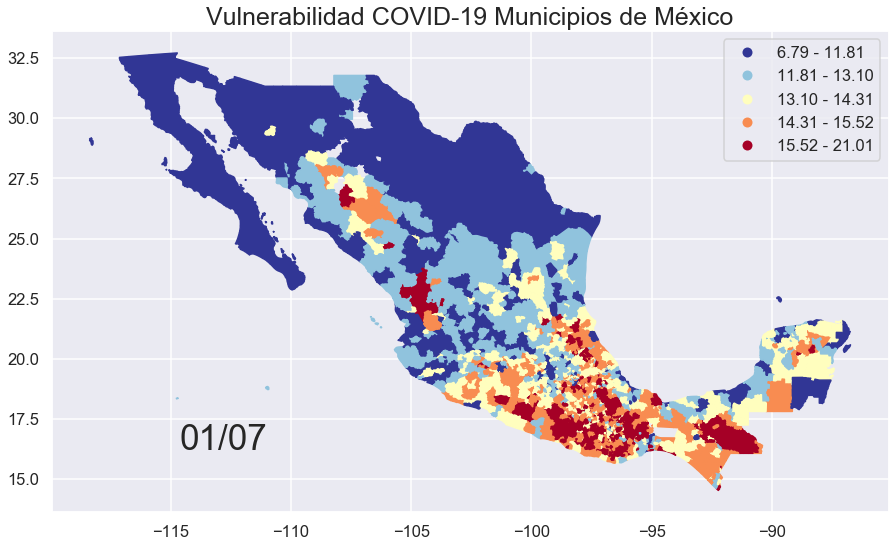

In [ ]:
fecha = datetime.datetime(2020, 7, 1)
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.modelo == 'PLS')]

fig, ax = plt.subplots(figsize=(15, 10))
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.valor.notna()].plot(column='valor', 
                                cmap='RdYlBu_r',
                                scheme='Quantiles',
                                k=5,
                                ax=ax,
                                legend=True,
                                edgecolor='face')
# remove axis of chart
# fig.axis('off')
fig.set_title('Vulnerabilidad COVID-19 Municipios de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)

plt.savefig(f'imagenes/vulnerabilidad_municipios_{fecha.strftime("%y%m%d")}.png')
plt.show()

## Mapa de letalidad 1 de junio de 2020

La letalidad en esa fecha se distribuía de la siguiente manera.

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.modelo == 'PLS')]

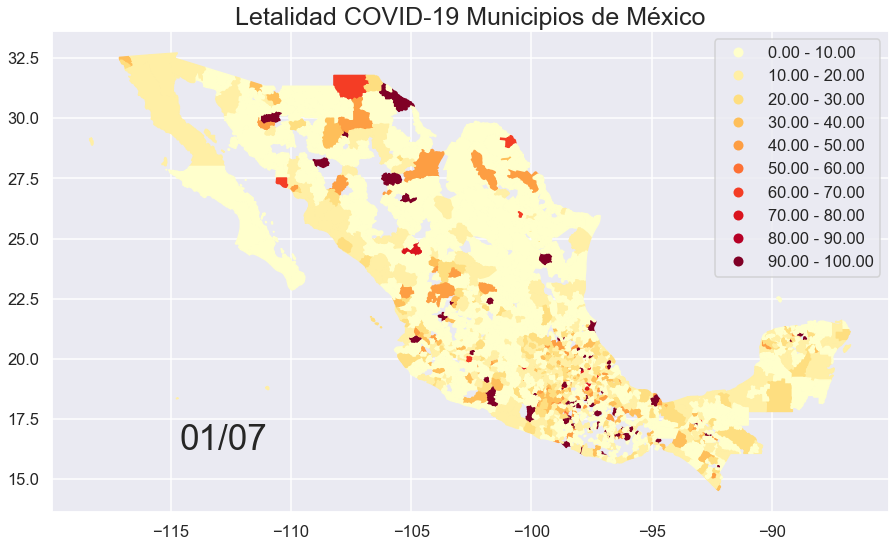

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.tasa_covid_letal.notna()].plot(column='tasa_covid_letal', 
                                cmap='YlOrRd',
                                scheme='EqualInterval',
                                k=10,
                                ax=ax,
                                legend=True,
                                edgecolor='face')
# remove axis of chart
fig.set_title('Letalidad COVID-19 Municipios de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)

plt.savefig(f'imagenes/letalidad_municipios_{fecha.strftime("%y%m%d")}.png')

plt.show()

Para el ajuste no se usan todos los municipios con casos, usamos los datos de municipios con al menos 20 confirmados. El siguiente mapa muestra la letalidad de los municipios que cumplen con esa condición.

In [ ]:
total_municipios = len(serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                                            (serie_vulnerabilidad.modelo == 'PLS')])
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.modelo == 'PLS') &
                          (serie_vulnerabilidad.conteo > 20)]

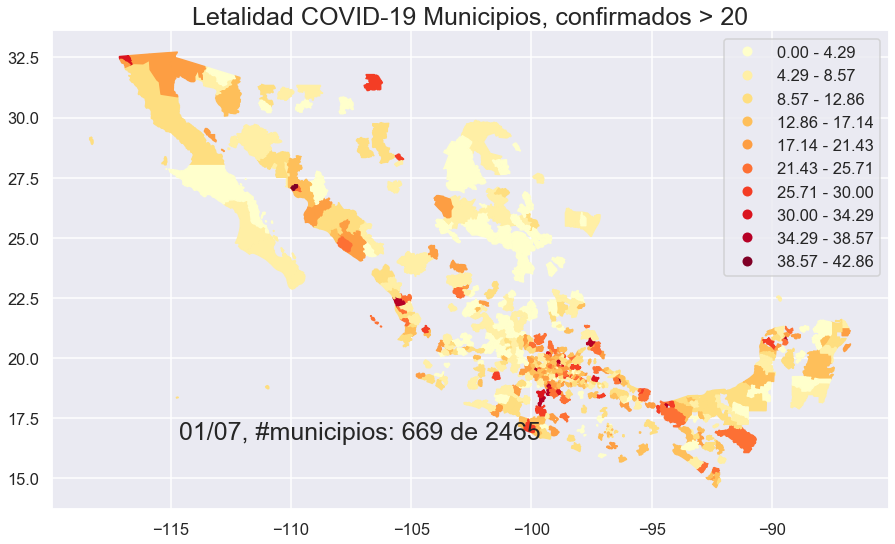

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.tasa_covid_letal.notna()].plot(column='tasa_covid_letal', 
                                cmap='YlOrRd',
                                scheme='EqualInterval',
                                k=10,
                                ax=ax,
                                legend=True,
                                edgecolor='face')
# remove axis of chart
fig.set_title('Letalidad COVID-19 Municipios, confirmados > 20', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(f'{fecha.strftime("%d/%m")}, #municipios: {len(df)} de {total_municipios}',
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=25)

plt.savefig(f'imagenes/letalidad_municipios_20_casos_{fecha.strftime("%y%m%d")}.png')

plt.show()

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.modelo == 'PLS')]
table = df[['MUNICIPIO_RES',
    'ENTIDAD_RES',
    'conteo',
    'defunciones',
    'tasa_covid_letal', 'pob2020']].sort_values(by='tasa_covid_letal', ascending=False).head(10)
table = table.reset_index(drop=True)
display(Markdown(table.to_markdown(showindex=False)))

| MUNICIPIO_RES   | ENTIDAD_RES   |   conteo |   defunciones |   tasa_covid_letal |   pob2020 |
|:----------------|:--------------|---------:|--------------:|-------------------:|----------:|
| SAN JERÓNIMO    | PUEBLA        |        1 |             1 |                100 |      6639 |
| TECUANIPAN      |               |          |               |                    |           |
| GUADALUPE       | CHIHUAHUA     |        2 |             2 |                100 |      5080 |
| ATLAMAJALCINGO  | GUERRERO      |        1 |             1 |                100 |      5284 |
| DEL MONTE       |               |          |               |                    |           |
| SAN PEDRO       | PUEBLA        |        1 |             1 |                100 |      3520 |
| YELOIXTLAHUACA  |               |          |               |                    |           |
| CHURUMUCO       | MICHOACÁN DE  |        1 |             1 |                100 |     15902 |
|                 | OCAMPO        |          |               |                    |           |
| SAN MIGUEL      | OAXACA        |        1 |             1 |                100 |      1054 |
| TEQUIXTEPEC     |               |          |               |                    |           |
| TAMIAHUA        | VERACRUZ DE   |        2 |             2 |                100 |     24459 |
|                 | IGNACIO DE LA |          |               |                    |           |
|                 | LLAVE         |          |               |                    |           |
| SANTIAGO        | OAXACA        |        1 |             1 |                100 |      1675 |
| IXCUINTEPEC     |               |          |               |                    |           |
| SANTA GERTRUDIS | OAXACA        |        1 |             1 |                100 |      2944 |
| PIAXTLA         | PUEBLA        |        2 |             2 |                100 |      4631 |

In [ ]:
table = df.loc[df.defunciones > 50, ['MUNICIPIO_RES',
    'ENTIDAD_RES',
    'conteo',
    'defunciones',
    'tasa_covid_letal', 'pob2020']].sort_values(by='tasa_covid_letal', ascending=False).head(10)
table = table.reset_index(drop=True)
display(Markdown(table.to_markdown(showindex=False)))

| MUNICIPIO_RES   | ENTIDAD_RES     |   conteo |   defunciones |   tasa_covid_letal |   pob2020 |
|:----------------|:----------------|---------:|--------------:|-------------------:|----------:|
| IGUALA DE LA    | GUERRERO        |      218 |            81 |            37.156  |    158141 |
| INDEPENDENCIA   |                 |          |               |                    |           |
| IXTLAHUACA      | MÉXICO          |      201 |            69 |            34.3284 |    163284 |
| TIJUANA         | BAJA CALIFORNIA |     2845 |           865 |            30.4042 |   1789531 |
| VALLE DE CHALCO | MÉXICO          |      512 |           145 |            28.3203 |    419700 |
| SOLIDARIDAD     |                 |          |               |                    |           |
| JUÁREZ          | CHIHUAHUA       |     1976 |           512 |            25.9109 |   1464930 |
| COATZACOALCOS   | VERACRUZ DE     |      892 |           214 |            23.991  |    339108 |
|                 | IGNACIO DE LA   |          |               |                    |           |
|                 | LLAVE           |          |               |                    |           |
| JIUTEPEC        | MORELOS         |      268 |            62 |            23.1343 |    227649 |
| CUAUTITLÁN      | MÉXICO          |      777 |           176 |            22.6512 |    577190 |
| IZCALLI         |                 |          |               |                    |           |
| CUERNAVACA      | MORELOS         |      745 |           168 |            22.5503 |    399426 |
| MINATITLÁN      | VERACRUZ DE     |      451 |           101 |            22.3947 |    164357 |
|                 | IGNACIO DE LA   |          |               |                    |           |
|                 | LLAVE           |          |               |                    |           |

## Mapa de letalidad 15 de julio

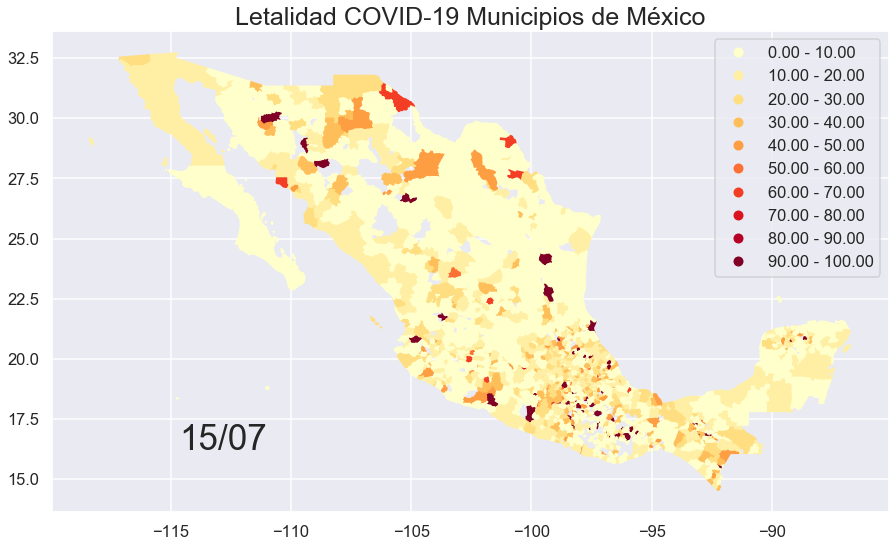

In [ ]:
fecha_futuro = datetime.datetime(2020, 7, 15)
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_futuro) &
                          (serie_vulnerabilidad.modelo == 'PLS')]

fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.tasa_covid_letal.notna()].plot(column='tasa_covid_letal', 
                                cmap='YlOrRd',
                                scheme='EqualInterval',
                                k=10,
                                ax=ax,
                                legend=True,
                                edgecolor='face')
# remove axis of chart
fig.set_title('Letalidad COVID-19 Municipios de México', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha_futuro.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)

plt.savefig(f'imagenes/letalidad_municipios_{fecha.strftime("%y%m%d")}.png')

plt.show()

In [ ]:
table = df[['MUNICIPIO_RES',
    'ENTIDAD_RES',
    'conteo',
    'defunciones',
    'valor',
    'tasa_covid_letal']].sort_values(by='tasa_covid_letal', ascending=False).head(10)
table = table.reset_index(drop=True)
display(Markdown(table.to_markdown()))

|    | MUNICIPIO_RES   | ENTIDAD_RES   |   conteo |   defunciones |   valor |   tasa_covid_letal |
|---:|:----------------|:--------------|---------:|--------------:|--------:|-------------------:|
|  0 | SAN PABLO       | OAXACA        |        1 |             1 | 15.0468 |                100 |
|    | YAGANIZA        |               |          |               |         |                    |
|  1 | SAN JERÓNIMO    | PUEBLA        |        1 |             1 | 14.7198 |                100 |
|    | TECUANIPAN      |               |          |               |         |                    |
|  2 | COATZINGO       | PUEBLA        |        1 |             1 | 14.6807 |                100 |
|  3 | JUÁREZ HIDALGO  | HIDALGO       |        1 |             1 | 12.4905 |                100 |
|  4 | CHAPULTENANGO   | CHIAPAS       |        1 |             1 | 15.1854 |                100 |
|  5 | CHAMULA         | CHIAPAS       |        1 |             1 | 17.1603 |                100 |
|  6 | CALTEPEC        | PUEBLA        |        3 |             3 | 14.9368 |                100 |
|  7 | SAN MIGUEL      | OAXACA        |        1 |             1 | 13.1802 |                100 |
|    | TEQUIXTEPEC     |               |          |               |         |                    |
|  8 | CHILA DE LA SAL | PUEBLA        |        1 |             1 | 13.5875 |                100 |
|  9 | HIDALGO         | TAMAULIPAS    |        1 |             1 | 12.6011 |                100 |

## Lista 10 municipios más vulnerables

De acuerdo con el índice, los diez municipios más vulnerables son los siguientes. Un dato notable es que de los diez municipios más vulnerables seis no tienen coasos reportados. En general los municipios más vulnerables son municipios con muy pocos casos, o sin casos.

In [ ]:
campos_tablas = ['ENTIDAD_RES', 'MUNICIPIO_RES',
                  'valor',
                  'conteo', 'pob2020',
                  'covid_confirmados_100k', 'tasa_covid_letal']
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                         (serie_vulnerabilidad.modelo == 'PLS')].copy()
display(Markdown(df.sort_values(by='valor', ascending=False).head(10)[campos_tablas].to_markdown(showindex=False)))

| ENTIDAD_RES   | MUNICIPIO_RES   |   valor |   conteo |   pob2020 |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|--------:|---------:|----------:|-------------------------:|-------------------:|
| OAXACA        | SANTOS REYES    | 21.0095 |        0 |      1352 |                  0       |           nan      |
|               | YUCUNÁ          |         |          |           |                          |                    |
| OAXACA        | SANTIAGO NUYOÓ  | 19.1521 |        0 |      1805 |                  0       |           nan      |
| OAXACA        | SAN JOSÉ        | 18.7459 |        3 |     18952 |                 15.8295  |            33.3333 |
|               | TENANGO         |         |          |           |                          |                    |
| OAXACA        | SANTA MARÍA     | 18.6055 |        0 |       386 |                  0       |           nan      |
|               | TATALTEPEC      |         |          |           |                          |                    |
| GUERRERO      | COCHOAPA EL     | 18.5787 |        1 |     19337 |                  5.17143 |             0      |
|               | GRANDE          |         |          |           |                          |                    |
| OAXACA        | SAN MARTÍN      | 18.5733 |        0 |      2320 |                  0       |           nan      |
|               | ITUNYOSO        |         |          |           |                          |                    |
| OAXACA        | SANTA INÉS      | 18.306  |        0 |       945 |                  0       |           nan      |
|               | YATZECHE        |         |          |           |                          |                    |
| OAXACA        | SAN MIGUEL      | 18.3054 |        0 |      3219 |                  0       |           nan      |
|               | TILQUIÁPAM      |         |          |           |                          |                    |
| OAXACA        | HUAUTEPEC       | 18.2887 |        0 |      6449 |                  0       |           nan      |
| OAXACA        | SAN MARTÍN      | 18.2604 |        0 |     12556 |                  0       |           nan      |
|               | PERAS           |         |          |           |                          |                    |

## Los 10 municipios menos vulnerables

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                         ((serie_vulnerabilidad.modelo == 'PLS'))].copy()
display(Markdown(df.sort_values(by='valor').head(10)[campos_tablas].to_markdown(showindex=False)))

| ENTIDAD_RES   | MUNICIPIO_RES   |   valor |   conteo |   pob2020 |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|--------:|---------:|----------:|-------------------------:|-------------------:|
| CIUDAD DE     | MIGUEL HIDALGO  | 6.79074 |     1938 |    379624 |                 510.505  |            9.18473 |
| MÉXICO        |                 |         |          |           |                          |                    |
| CIUDAD DE     | BENITO JUÁREZ   | 7.47223 |     1699 |    433708 |                 391.738  |           11.0065  |
| MÉXICO        |                 |         |          |           |                          |                    |
| NUEVO LEÓN    | MONTERREY       | 7.48868 |     1919 |   1124835 |                 170.603  |            4.58572 |
| CHIHUAHUA     | CHIHUAHUA       | 7.66239 |      709 |    949395 |                  74.6791 |           12.835   |
| CIUDAD DE     | CUAUHTÉMOC      | 7.96309 |     2892 |    548606 |                 527.154  |           12.9322  |
| MÉXICO        |                 |         |          |           |                          |                    |
| JALISCO       | GUADALAJARA     | 8.19028 |     2303 |   1503505 |                 153.175  |           13.5041  |
| SONORA        | HERMOSILLO      | 8.23356 |     2394 |    946054 |                 253.051  |            5.9315  |
| SONORA        | HUÉPAC          | 8.32019 |        0 |      1091 |                   0      |          nan       |
| SONORA        | SAN FELIPE DE   | 8.34828 |        0 |       449 |                   0      |          nan       |
|               | JESÚS           |         |          |           |                          |                    |
| YUCATÁN       | MÉRIDA          | 8.54944 |     2577 |    963861 |                 267.362  |            8.14901 |

In [ ]:
df = serie_vulnerabilidad.loc[((serie_vulnerabilidad.dia_ajuste == fecha) &
                         (serie_vulnerabilidad.modelo == 'PLS') &
                          (serie_vulnerabilidad.MUNICIPIO_RES == 'MONTERREY')),
                         ['valor', 'tasa_covid_letal'] + caracteristicas_indice].copy()
display(Markdown(df.T.to_markdown()))

## Los 10 municipios con más de 500K habitantes más vulnerables

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                         ((serie_vulnerabilidad.modelo == 'PLS'))].copy()
datos_md = df[df.pob2020 > 500000].sort_values(by='valor',
                                         ascending=False).head(10)[campos_tablas].to_markdown(showindex=False)

display(Markdown(datos_md))

| ENTIDAD_RES   | MUNICIPIO_RES   |   valor |   conteo |   pob2020 |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|--------:|---------:|----------:|-------------------------:|-------------------:|
| MÉXICO        | CHIMALHUACÁN    | 13.2439 |     1318 |    720207 |                 183.003  |           17.9818  |
| GUERRERO      | ACAPULCO DE     | 12.2625 |     3186 |    840795 |                 378.927  |           15.5367  |
|               | JUÁREZ          |         |          |           |                          |                    |
| MÉXICO        | IXTAPALUCA      | 12.2546 |     1145 |    551034 |                 207.791  |           19.3886  |
| MÉXICO        | NEZAHUALCÓYOTL  | 11.4399 |     3545 |   1135786 |                 312.119  |           16.7278  |
| JALISCO       | TONALÁ          | 11.4297 |      415 |    577668 |                  71.8406 |            9.63855 |
| MÉXICO        | ECATEPEC DE     | 11.3794 |     4073 |   1707754 |                 238.5    |           17.2109  |
|               | MORELOS         |         |          |           |                          |                    |
| MÉXICO        | TECÁMAC         | 11.0657 |      873 |    500585 |                 174.396  |           15.2348  |
| MÉXICO        | ATIZAPÁN DE     | 11.0373 |      933 |    557108 |                 167.472  |           18.2208  |
|               | ZARAGOZA        |         |          |           |                          |                    |
| JALISCO       | SAN PEDRO       | 11.0023 |      573 |    708568 |                  80.8673 |           12.5654  |
|               | TLAQUEPAQUE     |         |          |           |                          |                    |
| CHIAPAS       | TUXTLA          | 10.9273 |     1954 |    662591 |                 294.903  |           10.9519  |
|               | GUTIÉRREZ       |         |          |           |                          |                    |

## Los 10 municipios con más de 500K habitantes menos vulnerables

In [ ]:
datos_md = df[df.pob2020 > 500000].sort_values(by='valor').head(10)[campos_tablas].to_markdown(showindex=False)

In [ ]:
display(Markdown(datos_md))

| ENTIDAD_RES     | MUNICIPIO_RES   |   valor |   conteo |   pob2020 |   covid_confirmados_100k |   tasa_covid_letal |
|:----------------|:----------------|--------:|---------:|----------:|-------------------------:|-------------------:|
| NUEVO LEÓN      | MONTERREY       | 7.48868 |     1919 |   1124835 |                 170.603  |            4.58572 |
| CHIHUAHUA       | CHIHUAHUA       | 7.66239 |      709 |    949395 |                  74.6791 |           12.835   |
| CIUDAD DE       | CUAUHTÉMOC      | 7.96309 |     2892 |    548606 |                 527.154  |           12.9322  |
| MÉXICO          |                 |         |          |           |                          |                    |
| JALISCO         | GUADALAJARA     | 8.19028 |     2303 |   1503505 |                 153.175  |           13.5041  |
| SONORA          | HERMOSILLO      | 8.23356 |     2394 |    946054 |                 253.051  |            5.9315  |
| YUCATÁN         | MÉRIDA          | 8.54944 |     2577 |    963861 |                 267.362  |            8.14901 |
| SAN LUIS POTOSÍ | SAN LUIS POTOSÍ | 8.84628 |     1225 |    870578 |                 140.711  |            5.06122 |
| COAHUILA DE     | SALTILLO        | 8.88807 |      593 |    869184 |                  68.2249 |            3.87858 |
| ZARAGOZA        |                 |         |          |           |                          |                    |
| NUEVO LEÓN      | APODACA         | 8.96017 |      668 |    665734 |                 100.34   |            6.43713 |
| CIUDAD DE       | GUSTAVO A.      | 9.01704 |     6167 |   1176967 |                 523.974  |           16.264   |
| MÉXICO          | MADERO          |         |          |           |                          |                    |

# Datos

El índice de vulnerabilidad lo construimos relacionando indicadores de CONEVAL, INEGI y estadísticas CLUES, con la letalidad de COVID-19 observada en los municipios donde ya se han confirmado casos de infección de Sars-Cov-2.

Las fuentes de datos para el conjunto de indicadores pertenecen a cuatro categorías. La siguiente lista presenta la fuente y la categoría a la que pertence cada conjunto de indicadores:

1. Social:
    * Fuente: CONEVAL, rezago social, 2015
    * Producto: Índice de rezago social por municipio
    * URL: 
2. Economía:
    * Fuente: CONEVAL, pobreza, 2015
    * Producto: Indicadores de pobreza por municipio
    * URL: https://datos.gob.mx/busca/dataset/indicadores-de-pobreza-municipal-2010--2015
3. Salud:
    * Fuente: INEGI
    * Producto: estadísticas vitales, 2015
4. Infraestructura de salud:
    * Fuente: CLUES, 2018
    
    

# Método

Para construir el índice de vulnerabilidad integramos un conjunto de indicadores sociales, económicos y de salubridad y encontramos la combinación de estos que más se relaciona con el nivel de letalidad de COVID-19. Con esta combinación generamos el índice, el cuál nos indica el grado en que la población de un municipio es suceptible a tener complicaciones por COVID-19. 

Como proxy de vulnerabilidad utilizamos la letalidad observada de COVID-19 en cada municipio y ajustamos una regresión usando como variables independientes indicadores de los municipios sobre carencias sociales, de pobreza, de salud y de infrestructura de salud. Para realizar este ajuste sólo consideramos municipios con al menos diez casos confirmados. 

El método para construir este índice es regresión por mínimos cuadrados parciales. Este método busca la combinación de indicadores que explica más sobre la letalidad de COVID-19 en una población. Del ajuste obtenemos una función que calcula el índice de vulnerabilidad para cada municipio, y coeficientes para cada indicador, los cuáles nos indican la relevancia que cada uno tiene en el resultado del índice, dada por la magnitud del coeficiente, y según el signo también sabemos en que dirección se asocia el indicador con la letalidad, por ejemplo, como veremos más adelante, el indicador *npnv* (porcentaje de la población que no es pobre ni vulnerable de acuerdo con CONEVAL) es de los indicadores con mayor peso pero en sentido inverso.  

## Mínimos cuadrados parciales (PLS)
**PLS**: Partial least squares

**PLS**: Projection to latent structures

Ventajas:

* Similar a PCA pero dirigido a maximizar la covarianza entre X y Y.
* Conjuga el objetivo de PCA y regresión lineal multivariada
* Robusto ante colinearidades en X y/o Y
* Permite integrar más de una variable en Y (Y es una matriz)
* Robusto cuando el número de variables es mayor que el número de observaciones

![Diagrama PLS](imagenes/diagrama_pls_latentes.png)
Fuente: JA Wegelin, A survey of Partial Least Squares (PLS) methods, with emphasis on the two-block case

![PLS, MLR y PCA](imagenes/PLS_MLR_PCA_elipsis.png)
Fuente: http://www.eigenvector.com/Docs/Wise_pls_properties.pdf

\begin{equation}
X = T P^T + E \\
Y = U Q^T + F
\end{equation}

Donde T, U son proyecciones de X y Y que maximizan cov(X, Y).

* Busca la dirección de máxima covarianza entre $X$ y $Y$.
* Algoritmo: PLS1 (caso de PLS2 con Y vector)
* PLS1 es regresión con regularización


Referencias: https://en.wikipedia.org/wiki/Partial_least_squares_regression, https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

## Especificación modelo

* **Fechas de datos para análisis**: 24 de abril al 15 de julio de 2020
* **URL**: [Datos abiertos de COVID-19](https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia): https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia
* **Implementación PLS**:  [Scikit Learn - PLSRegression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression)

# Detalle de resultados

Los siguientes mapas nos muestran como cambia la letalidad y el efecto en el mapa de vulnerabilidad. En este ejemplo vemos el cambio que hubo en un mes. Lo que nos interesa de esta comparación es que el mapa de vulnerabilidad no tiene cambios muy fuertes. 

## Análisis por entidades

En esta sección presentamos como se distribuyen la letalidad y el índice de vulnerabilidad por entidad. El siguiente mapa muestra la vulnerabilidad promedio por entidad. 

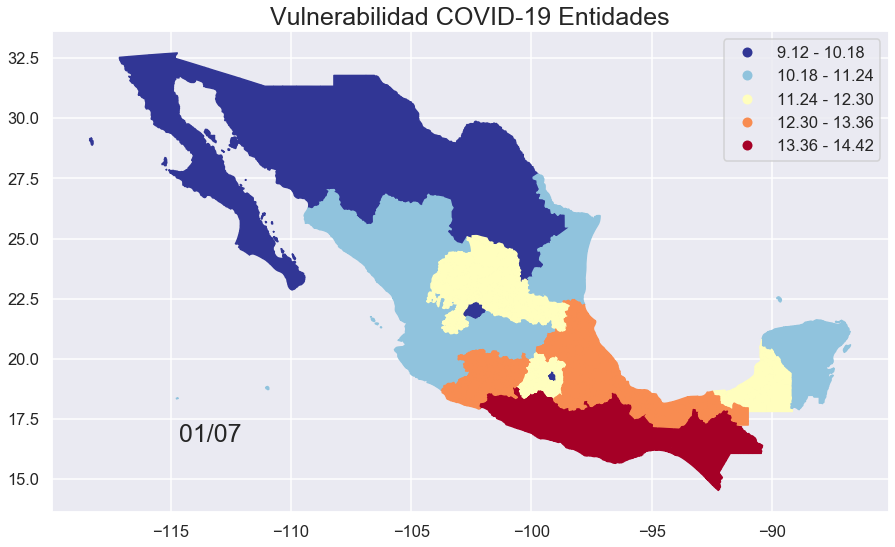

In [ ]:
vulnerabilidad_entidad = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha)  &
                                             (serie_vulnerabilidad.modelo == 'PLS')]
vulnerabilidad_entidad = vulnerabilidad_entidad[['ENTIDAD_RES', 'geometry', 'letalidad_entidad', 'valor_entidad']]


fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = vulnerabilidad_entidad.plot(column='valor_entidad',
                                  cmap='RdYlBu_r',
                                  scheme="EqualInterval",
                                  legend=True,
                                  k=5,
                                  edgecolor="face", ax=ax)

# remove axis of chart
fig.set_title('Vulnerabilidad COVID-19 Entidades', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=25)

plt.savefig(f'imagenes/vulnerabilidad_entidades_{fecha.strftime("%y%m%d")}.png')

El siguiente muestra la letalidad promedio por entidad.

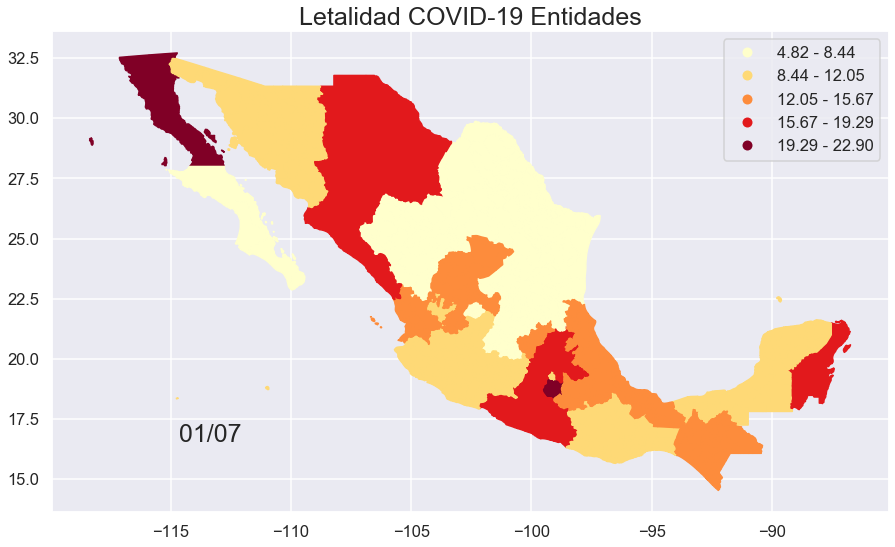

In [ ]:
letalidad_entidad = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha)  &
                                         (serie_vulnerabilidad.modelo == 'PLS')]
letalidad_entidad = letalidad_entidad[['ENTIDAD_RES', 'geometry', 'letalidad_entidad', 'valor_entidad']].drop_duplicates()

fig, ax = plt.subplots(figsize=(15, 10))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = letalidad_entidad.plot(column='letalidad_entidad',
                             cmap='YlOrRd',
                             scheme="EqualInterval",
                             legend=True,
                             k=5,
                             edgecolor="face", ax=ax)

# remove axis of chart
fig.set_title('Letalidad COVID-19 Entidades', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=25)

plt.savefig(f'imagenes/letalidad_entidades_{fecha.strftime("%y%m%d")}.png')

In [ ]:
datos = letalidad_entidad.sort_values(by='letalidad_entidad', ascending=False)
datos_md = datos.drop(columns='geometry').drop_duplicates().to_markdown(showindex=False)
display(Markdown(datos_md))

| ENTIDAD_RES     |   letalidad_entidad |   valor_entidad |
|:----------------|--------------------:|----------------:|
| BAJA CALIFORNIA |            22.9027  |         9.86161 |
| MORELOS         |            22.6921  |        12.1933  |
| GUERRERO        |            19.2285  |        14.2285  |
| HIDALGO         |            17.935   |        12.6269  |
| CHIHUAHUA       |            17.9285  |         9.12736 |
| QUINTANA ROO    |            17.4444  |        10.7939  |
| TLAXCALA        |            16.6966  |        12.6672  |
| MÉXICO          |            16.2023  |        11.963   |
| SINALOA         |            16.1163  |        10.308   |
| PUEBLA          |            15.3972  |        13.1118  |
| VERACRUZ DE     |            14.8525  |        13.335   |
| IGNACIO DE LA   |                     |                 |
| LLAVE           |                     |                 |
| QUERÉTARO       |            13.9482  |        10.6311  |
| CHIAPAS         |            13.4232  |        14.4188  |
| NAYARIT         |            12.8511  |        11.1485  |
| ZACATECAS       |            12.3046  |        11.5685  |
| CIUDAD DE       |            11.6457  |         9.35206 |
| MÉXICO          |                     |                 |
| CAMPECHE        |            10.8062  |        11.454   |
| MICHOACÁN DE    |            10.7967  |        13.0554  |
| OCAMPO          |                     |                 |
| SONORA          |            10.5049  |         9.7733  |
| OAXACA          |            10.3718  |        14.155   |
| YUCATÁN         |            10.2524  |        11.0877  |
| TABASCO         |            10.2048  |        12.3284  |
| COLIMA          |             9.55172 |        10.6356  |
| JALISCO         |             9.54612 |        10.4182  |
| DURANGO         |             8.31493 |        10.7995  |
| TAMAULIPAS      |             6.57878 |        10.7377  |
| AGUASCALIENTES  |             6.03222 |         9.83617 |
| NUEVO LEÓN      |             6.01868 |         9.11977 |
| SAN LUIS POTOSÍ |             5.96977 |        11.3523  |
| COAHUILA DE     |             5.3773  |         9.57622 |
| ZARAGOZA        |                     |                 |
| BAJA CALIFORNIA |             5.24322 |        10.0476  |
| SUR             |                     |                 |
| GUANAJUATO      |             4.8214  |        11.1073  |

### Letalidad por entidad

El siguiente diagrama de cajas muestra cómo se distribuye la letalidad para cada entidad, considerando municipios con más de **3** defunciones por COVID-19 reportadas. Cada punto es un municipio donde la altura representa la letalidad de COVID-19 observada en ese muncipio. 

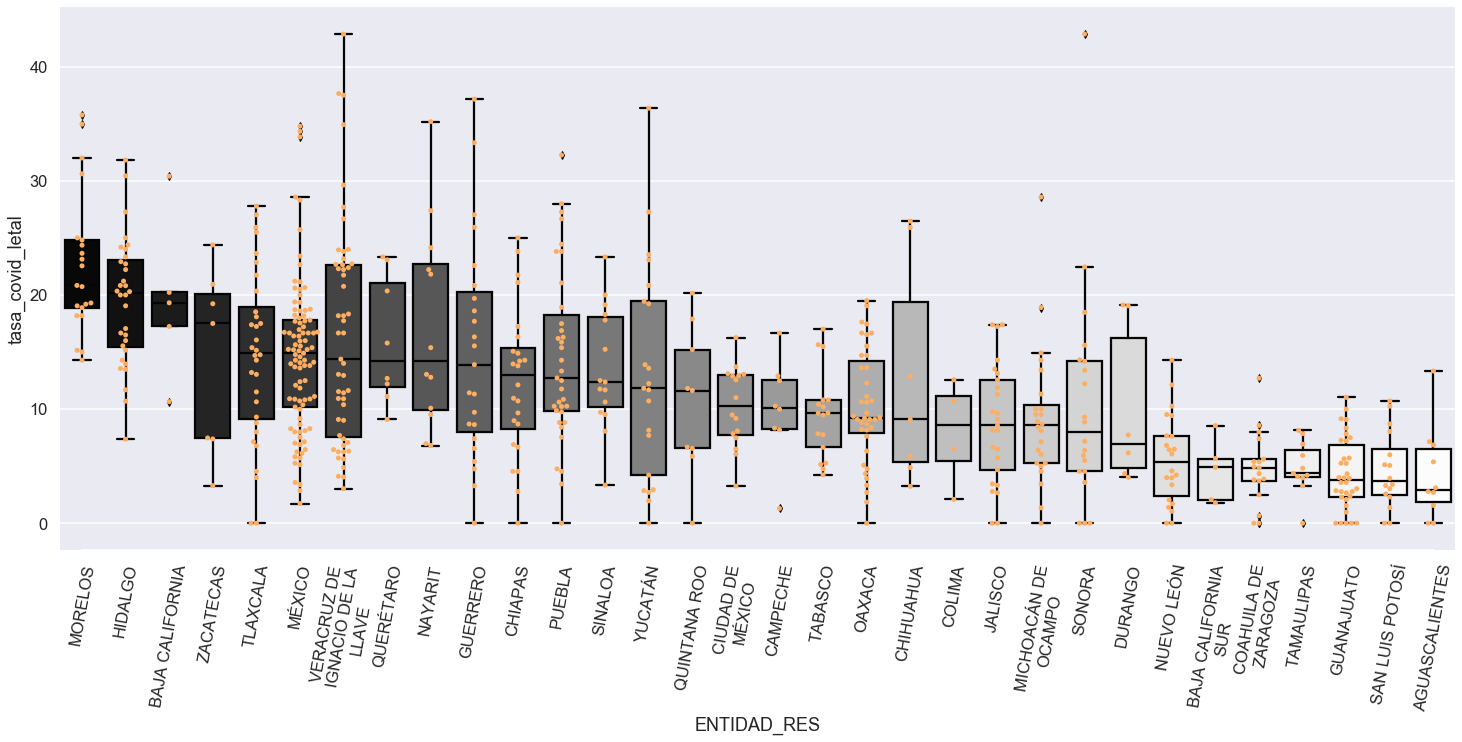

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.conteo > 20)  &
                          (serie_vulnerabilidad.modelo == 'PLS')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['tasa_covid_letal'].transform('median')
df.sort_values(by='mean_val', ascending=False, inplace=True)

sns.boxplot(data=df, y='tasa_covid_letal', x='ENTIDAD_RES', saturation=0.3, palette='Greys_r')
sns.swarmplot(data=df, y='tasa_covid_letal', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

plt.savefig(f'imagenes/letalidad_entidades_boxplot_conteo_20_{fecha.strftime("%y%m%d")}.png')

De los municpios desplegados arriba los municipios con mayor letalidad son:

In [ ]:
datos_md = df.sort_values(by='tasa_covid_letal', ascending=False)[campos_tablas].head(10).to_markdown(showindex=False)
display(Markdown(datos_md))

| ENTIDAD_RES   | MUNICIPIO_RES   |   valor |   conteo |   pob2020 |   covid_confirmados_100k |   tasa_covid_letal |
|:--------------|:----------------|--------:|---------:|----------:|-------------------------:|-------------------:|
| SONORA        | BENITO JUÁREZ   | 11.8463 |       21 |     23843 |                  88.0762 |            42.8571 |
| VERACRUZ DE   | MANLIO FABIO    | 13.4692 |       28 |     24849 |                 112.681  |            42.8571 |
| IGNACIO DE LA | ALTAMIRANO      |         |          |           |                          |                    |
| LLAVE         |                 |         |          |           |                          |                    |
| VERACRUZ DE   | NANCHITAL DE    | 11.3208 |       85 |     31215 |                 272.305  |            37.6471 |
| IGNACIO DE LA | LÁZARO CÁRDENAS |         |          |           |                          |                    |
| LLAVE         | DEL RÍO         |         |          |           |                          |                    |
| VERACRUZ DE   | IXHUATLÁN DEL   | 12.6796 |       24 |     16524 |                 145.243  |            37.5    |
| IGNACIO DE LA | SURESTE         |         |          |           |                          |                    |
| LLAVE         |                 |         |          |           |                          |                    |
| GUERRERO      | IGUALA DE LA    | 13.1384 |      218 |    158141 |                 137.852  |            37.156  |
|               | INDEPENDENCIA   |         |          |           |                          |                    |
| YUCATÁN       | ACANCEH         | 12.4736 |       44 |     17390 |                 253.019  |            36.3636 |
| MORELOS       | PUENTE DE IXTLA | 13.6654 |      137 |     70917 |                 193.184  |            35.7664 |
| NAYARIT       | TECUALA         | 11.8557 |       54 |     43043 |                 125.456  |            35.1852 |
| MORELOS       | TEMIXCO         | 12.9115 |      123 |    123812 |                  99.3442 |            34.9593 |
| VERACRUZ DE   | TIHUATLÁN       | 14.4306 |       63 |    100967 |                  62.3966 |            34.9206 |
| IGNACIO DE LA |                 |         |          |           |                          |                    |
| LLAVE         |                 |         |          |           |                          |                    |

El criterio de desplegar municipios con más de 3 defunciones se aplicó para limpiar los datos. A continuación se presenta el mismo diagrama pero considerando todos los municipios con casos de Sars-CoV-2, se observa que hay varios municipios con cero defunciones y otros con letalidad de 100%, estos dos casos extremos se presentan con mayor frecuencia y se salen de la distribución de valores de letalidad, esto sucede en general con municpios que han reportado pocos casos. 

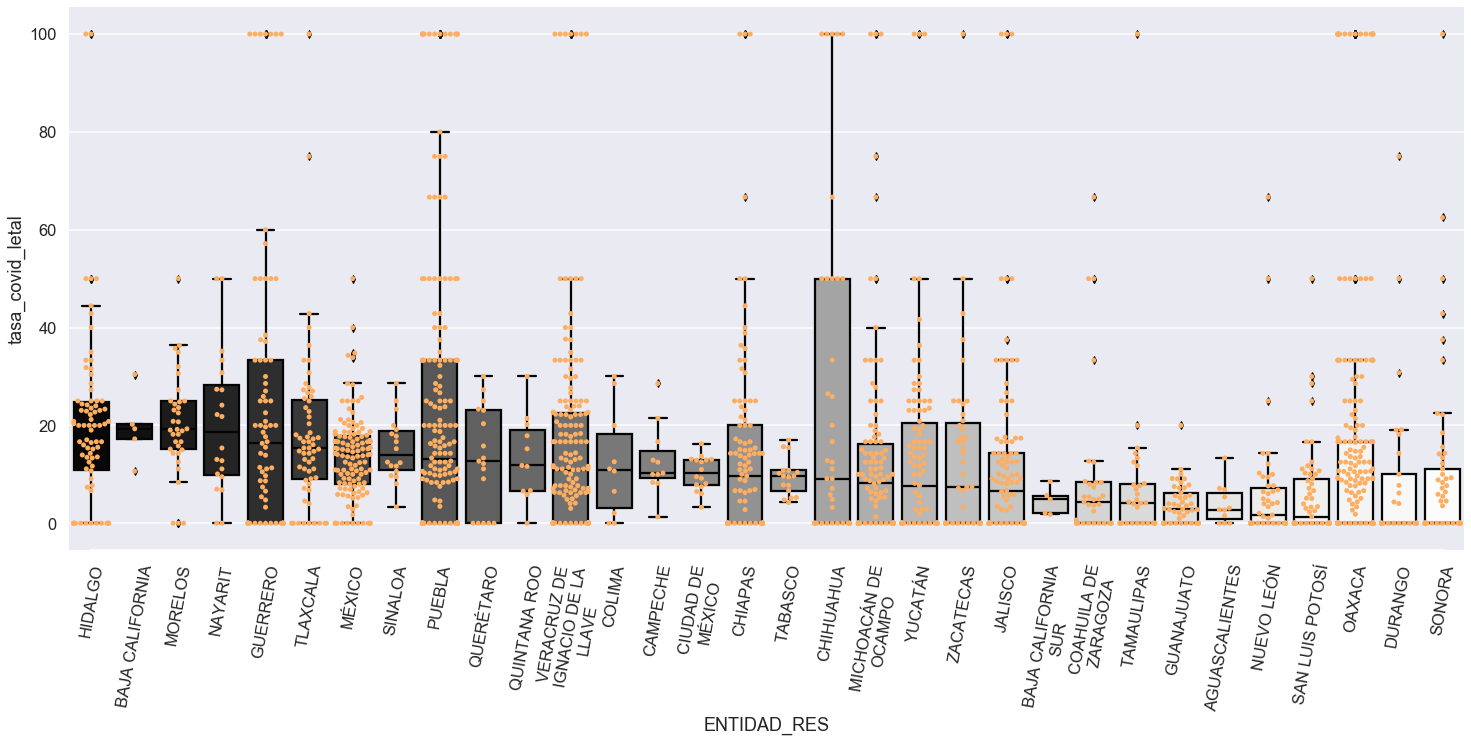

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.modelo == 'PLS')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['tasa_covid_letal'].transform('median')
df.sort_values(by='mean_val', ascending=False, inplace=True)

sns.boxplot(data=df[df.conteo > 0], y='tasa_covid_letal', x='ENTIDAD_RES', saturation=0.3, palette='Greys_r')
sns.swarmplot(data=df[df.conteo > 0], y='tasa_covid_letal', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)
plt.savefig(f'imagenes/letalidad_boxplot_{fecha.strftime("%y%m%d")}.png')

### Vulnerabilidad por entidad

La siguiente gráfica muestra la distribución de vulnerabilidad de los municipios por entidad. Al igual que en la anterior, cada punto representa un municipio y la posición en el eje *y* está dada por el valor del índice de vulnerabilidad. El orden en el que se despliegan las entidades está dado por la mediana de vulnerabilidad.

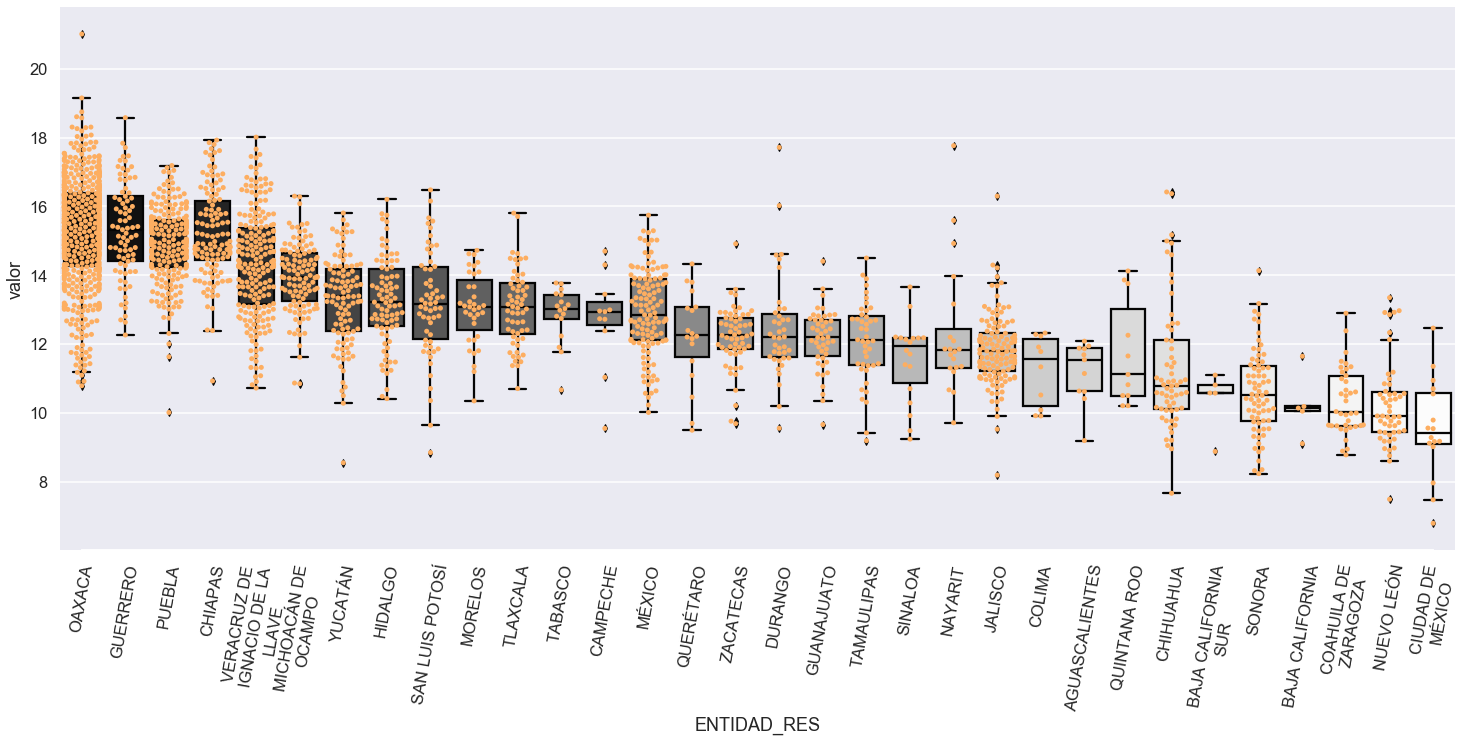

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha)
                           &
                          (serie_vulnerabilidad.modelo == 'PLS')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['valor'].transform('median')
sns.boxplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', palette='Greys_r')
sns.swarmplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)
plt.savefig(f'imagenes/vulnerabilidad_boxplot_{fecha.strftime("%y%m%d")}.png')

### Relación entre el índice de vulnerabilidad y la letalidad

In [ ]:
reg_df = df[(df.conteo > 0) & df.valor.notna()]
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)

Los resultados muestran que para municipios donde existen defunciones reportadas, la correlación entre el índice de vulnerabilidad y la letalidad es positiva. Si calculamos la correlación de Spearman entre letalidad y vulnerabilidad para los municipios con al menos una defunción obtenemos:

In [ ]:
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.019


##### Si cambiamos a municipios con al menos 5 defunciones reportadas, la correlación aumenta aproximadamente 15% a:

In [ ]:
reg_df = df[(df.defunciones > 5) & df.valor.notna()]
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)

In [ ]:
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.427


En los siguientes diagramas de dispersión mostramos esta relación. En el primer diagrama desplegamos todos los municipios con al menos una defunción reportada. Ahí podemos ver las líneas verticales de puntos generadas por municipios con pocas defunciones reportadas (entre una y tres defunciones).

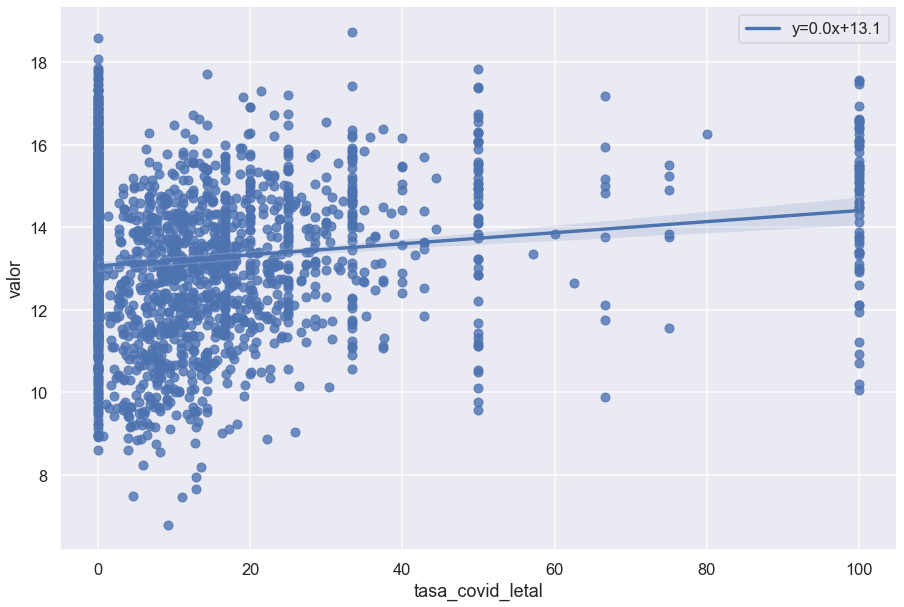

In [ ]:
reg_df = df[(df.conteo > 0) & df.valor.notna()]
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.savefig(f'imagenes/correlacion_pls_{fecha.strftime("%y%m%d")}.png')
plt.show()

Si eliminamos esos municipios y desplegamos unicamente los que tienen al menos 5 defunciones reportadas se eliminan por completo esas líneas y mejora la relación entre las variables.

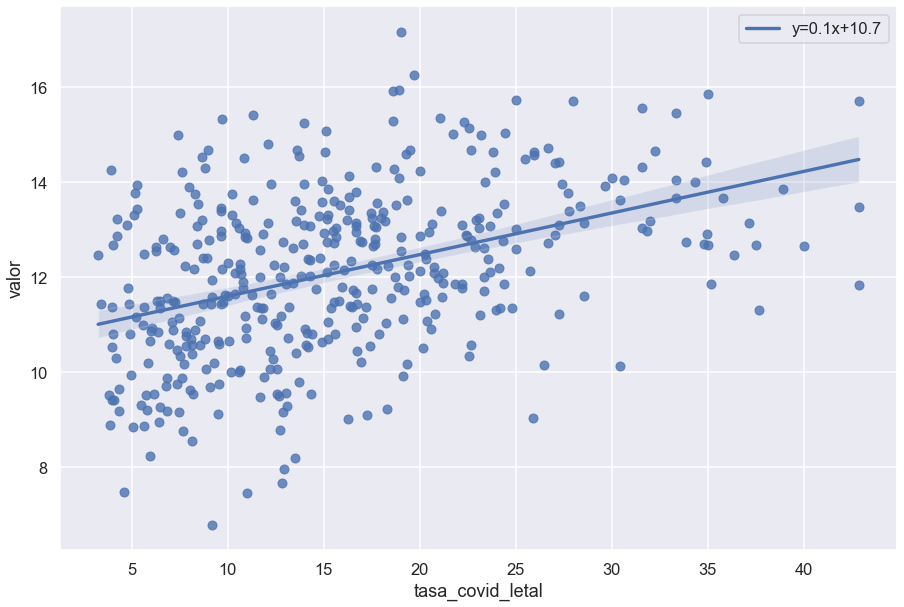

In [ ]:
reg_df = df[(df.defunciones > 5)]
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.savefig(f'imagenes/correlacion_pls_conteo_20_{fecha.strftime("%y%m%d")}.png')
plt.show()

## Serie de modelos PLS (24/04/2020 - 15/07/2020)

El ajuste de la regresión por PLS asigna coeficientes a cada uno de los indicadores que estamos considerando, donde la magnitud del coeficiente nos indica el tamaño de la relación que se encontró entre el indicador y la letalidad, y el signo nos indica si la relación es proporcional, es decir, si valores grandes del indicador se relacionan con alta vulnerabilidad, o es inversamente proporcional, si conforme crece el valor del indicador decrece el de vulnerabilidad.

El siguiente es un análisis de los modelos resultantes de ajustar una regresión por cada conjunto de datos publicado en el periódo que va del 24/04/2020 al 15/06/2020, es decir para cada día se calculó un modelo de vulnerabilidad. A continuación mostramos las descripciones de los indicadores y cómo se mueven sus coeficientes conforme cambian los datos.

### Descripción de los indicadores

In [ ]:
modelos['mediana'] = modelos.groupby(['caracteristica', 'modelo'])['coef'].transform('median')
modelos_pls = modelos[(modelos.dia_ajuste <= fecha) & (modelos.modelo == 'PLS')].copy()


In [ ]:
# from ipypublish import nb_setup
# pd = nb_setup.setup_pandas(escape_latex=False)

lista_cars = list(modelos_pls.sort_values(by='mediana', ascending=False)["caracteristica"].drop_duplicates())
pd.set_option('display.max_colwidth', 0)

diccionario_indicadores = diccionario_indicadores.set_index('campo').loc[lista_cars].reset_index()
diccionario_indicadores.campo = diccionario_indicadores.campo.str.strip()
diccionario_indicadores.descriptor = diccionario_indicadores.descriptor.str.wrap(width=60)
diccionario_indicadores.descriptor = diccionario_indicadores.descriptor.str.strip()
dicc_md = diccionario_indicadores.to_markdown(showindex=False)
display(Markdown(dicc_md))

| campo                     | descriptor                                                                              |
|:--------------------------|:----------------------------------------------------------------------------------------|
| vnl_2015                  | Viviendas que no disponen de lavadora,2015                   |
| carencias                 | %Población con al menos una carencia social                  |
| pobreza_m                 | %Población en situación de pobreza moderada                  |
| pobreza                   | % Población en situación de pobreza                          |
| irs_2015                  | Índice de rezago social,2015                                 |
| ic_segsoc                 | %Carencia por acceso a la seguridad social                   |
| vnr_2015                  | Viviendas que no disponen de refrigerador,2015               |
| ic_ali                    | %Carencia por acceso a la alimentación                       |
| plb                       | %Población con igreso inferior a la línea de bienestar       |
| carencias3                | %Población con al menos tres carencias sociales              |
| ic_cv                     | %Carencia por calidad y espacios en la vivienda              |
| an_2015                   | 15 años y más analfabetas,2015                               |
| plbm                      | %Población con ingreso inferior a la línea de bienestar      |
|                           | mínimo                                                       |
| bi_2015                   | 15 años y más con educación básica incompleta,2015           |
| ic_sbv                    | %Carencia por acceso a los servicios básicos en la vivienda  |
| pobreza_e                 | %Población en situación de pobreza extrema                   |
| vpt_2015                  | Viviendas piso  de tierra,2015                               |
| vna_2015                  | Viviendas sin Agua,2015                                      |
| tasa_diabetes             | Diabetes mellitus.                                           |
| ic_asalud                 | %Carencia por acceso a los servicios de salud                |
| ic_rezedu                 | %Indicadores de carencia social  Rezago educativo            |
| sins_15                   | Porcentaje de Población  sin derechohabiencia a salud,2015   |
| vns_2015                  | Viviendas sin sanitario,2015                                 |
| vnd_2015                  | Viviendas que no disponen de drenaje,2015                    |
| hospitales_pemex          | Unidades econmicas dedicadas principalmente a proporcionar                                                              |
|                           | servicios médicos, que cuentan con las instalaciones para                                                               |
|                           | la hospitalizaci³n de los pacientes.                                                                                    |
| vne_2015                  | Viviendas que no disponen de energía eléctrica,2015          |
| ne614_015                 | 6 a 14 años que no asisten a la escuela,2015                 |
| vul_car                   | %Población vulnerable por carencias sociales                 |
| hospitales_privados       | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| total_de_camas_privados   | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_imss           | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| consulto_1                | Unidades económicas de dicadas principalmente a proporcionar |
|                           | servicios de consulta médica externa general o especializada |
|                           | (como servicios médicos especializados en cardiología,       |
|                           | gastroenterología, otorrinolaringología, ginecología,        |
|                           | homeopatí­a, nutrición, psiquiatrí­a, oftalmología)          |
|                           | prestados por profesionistas con estudios mí­nimos de        |
|                           | licenciatura en medicina.                                    |
| hospitales_semar          | Unidades econmicas dedicadas principalmente a proporcionar                             |
|                           | servicios mdicos, que cuentan con las instalaciones para la                            |
|                           | hospitalización de los pacientes.                                                       |
| farmacias                 | Unidades económicas dedicadas principalmente al comercio al  |
|                           | por menor de medicamentos, productos naturistas y            |
|                           | complementos alimenticios para consumo humano.               |
| consultori                | Unidades económicas de dicadas principalmente a proporcionar |
|                           | servicios de consulta médica externa general o especializada |
|                           | (como servicios médicos especializados encardiología,        |
|                           | gastroenterología, otorrinolaringología, ginecología,        |
|                           | homeopatí­a, nutrición, psiquiatrí­a, oftalmología)          |
|                           | prestados por profesionistas con estudios mí­nimos de        |
|                           | licenciatura en medicina.                                    |
| hospitales_sme            | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| tasa_cancer               | Tumores (neoplasias), Tumores malignos del labio, de la      |
|                           | cavidad bucal y de la faringe, Tumor maligno del esófago,    |
|                           | Tumor maligno del estómago, Tumor maligno del colon, del     |
|                           | recto y del ano, Tumor maligno del hí­gado y de las ví­as    |
|                           | biliares intrahepáticas, Tumor maligno del páncreas, Tumor   |
|                           | maligno de la laringe, Tumor maligno de la tráquea, de los   |
|                           | bronquios y del pulmón, Melanoma maligno de la piel, Tumor   |
|                           | maligno de la mama, Tumor maligno del cuello del útero,      |
|                           | Tumor maligno de otras partes y de las no especificadas del  |
|                           | útero, Tumor maligno del ovario, Tumor maligno de la         |
|                           | próstata, Tumor maligno de la vejiga urinaria, Tumor maligno |
|                           | de las meninges, del encí©falo y de otras partes del sistema |
|                           | nervioso central, Linfoma no Hodgkin, Mieloma múltiple y     |
|                           | tumores malignos de cí©lulas plasmáticas y Leucemia.         |
| total_camas               | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| porc_carencia_salud       | Se considera que una persona se encuentra en situación de    |
|                           | carencia por acceso a los servicios de salud cuando:  No     |
|                           | cuenta con adscripción o derecho a recibir servicios médicos |
|                           | de alguna institución que los presta, incluyendo el Seguro   |
|                           | Popular, las instituciones públicas de seguridad social      |
|                           | (IMSS, ISSSTE federal o estatal, Pemex, Ejí©rcito o Marina)  |
|                           | o los servicios médicos privados.                            |
| hospitales_ssa            | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| tasa_pulmonares           | Enfermedades del sistema respiratorio, Influenza (gripe),    |
|                           | Neumoní­a, Otras infecciones agudas de las ví­as             |
|                           | respiratorias inferiores y Enfermedades crónicas de las      |
|                           | ví­as respiratorias inferiores.                              |
| tasa_cardiacas            | Enfermedades del sistema circulatorio, Fiebre reumática      |
|                           | aguda y enfermedades cardí­acas reumáticas crónicas,         |
|                           | Enfermedades hipertensivas, Enfermedades isquí©micas del     |
|                           | corazón, Otras enfermedades del corazón, Enfermedades        |
|                           | cerebrovasculares y Aterosclerosis.                          |
| total_camas_publicos      | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| total_hospitales_publicos | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_sedena         | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| hospitales_issste         | Unidades económicas dedicadas principalmente a proporcionar  |
|                           | servicios médicos, que cuentan con las instalaciones para la |
|                           | hospitalización de los pacientes.                            |
| vul_ing                   | %Población vulnerable por ingresos                           |
| lmex_2015                 | Lugar que ocupa en el contexto nacional,2015                 |
| npnv                      | %Población no pobre y no vulnerable                          |

In [ ]:
df = serie_vulnerabilidad.loc[((serie_vulnerabilidad.dia_ajuste == fecha) &
                         (serie_vulnerabilidad.modelo == 'PLS') &
                          (serie_vulnerabilidad.MUNICIPIO_RES == 'MEZQUITAL')),
                         lista_cars].copy()
display(Markdown(df.T.to_markdown()))

### Distribución de valores de coeficientes por indicador

Este diagrama de cajas muestra los indicadores ordenados con respecto a la mediana de sus coeficientes, en él podemos ver el rango en el que se movieron los coeficientes a lo largo del periodo. Es importante notar que aunque los coeficientes de algunos indicadores se mueven en rangos relativamente amplios, en su mayoría se mantienen o en valores positivos o en negativos. 

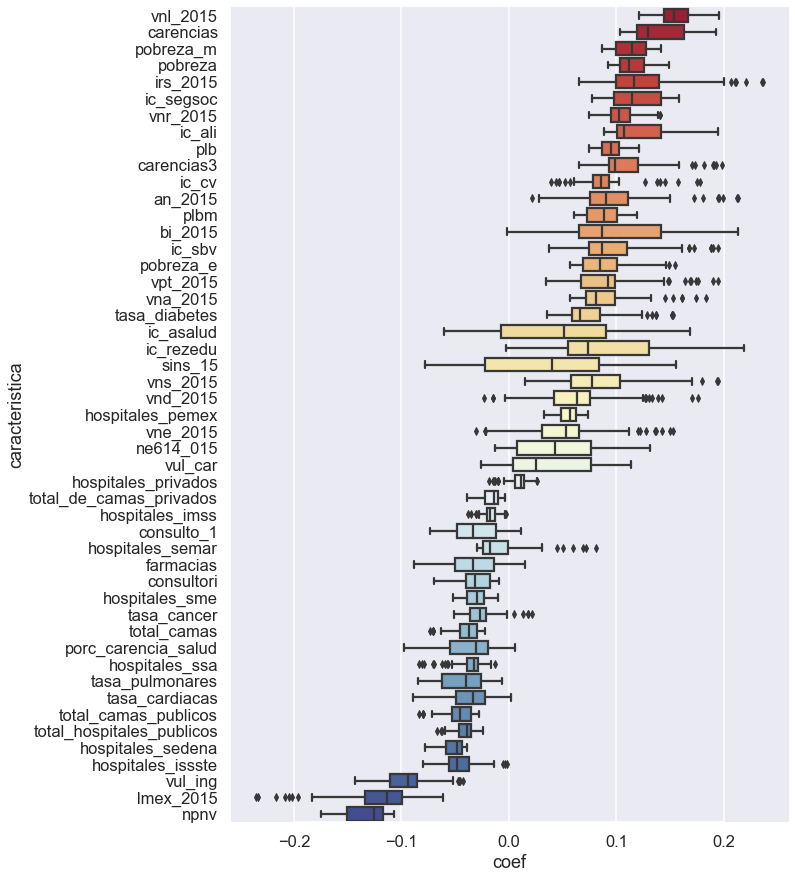

In [ ]:
fecha_futuro = datetime.datetime(2020, 7, 15)
# pd.set_option('display.max_colwidth', 50)
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(y="caracteristica", x="coef",
            data=modelos_pls.sort_values(by='mediana', ascending=False),
            palette='RdYlBu')
sns.despine(trim=True, left=True)
plt.savefig(f'imagenes/coeficientes_pls_{fecha_futuro.strftime("%y%m%d")}.png')
plt.show()

### Series de tiempo de coeficientes por indicador

Las siguientes gráficas muestran cómo cambian los coeficientes de los indicadores conforme avanzamos en el día de publicación del conjunto de datos. En general se puede ver que los coeficientes se estabilizan a medida que avanza el tiempo. Además de entender cómo cambia el resultado del ajuste conforme se actualizan los datos, este análisis es una herramienta que podría ayudarnos a detectar cambios en el patrón de letalidad de la epidemia.  

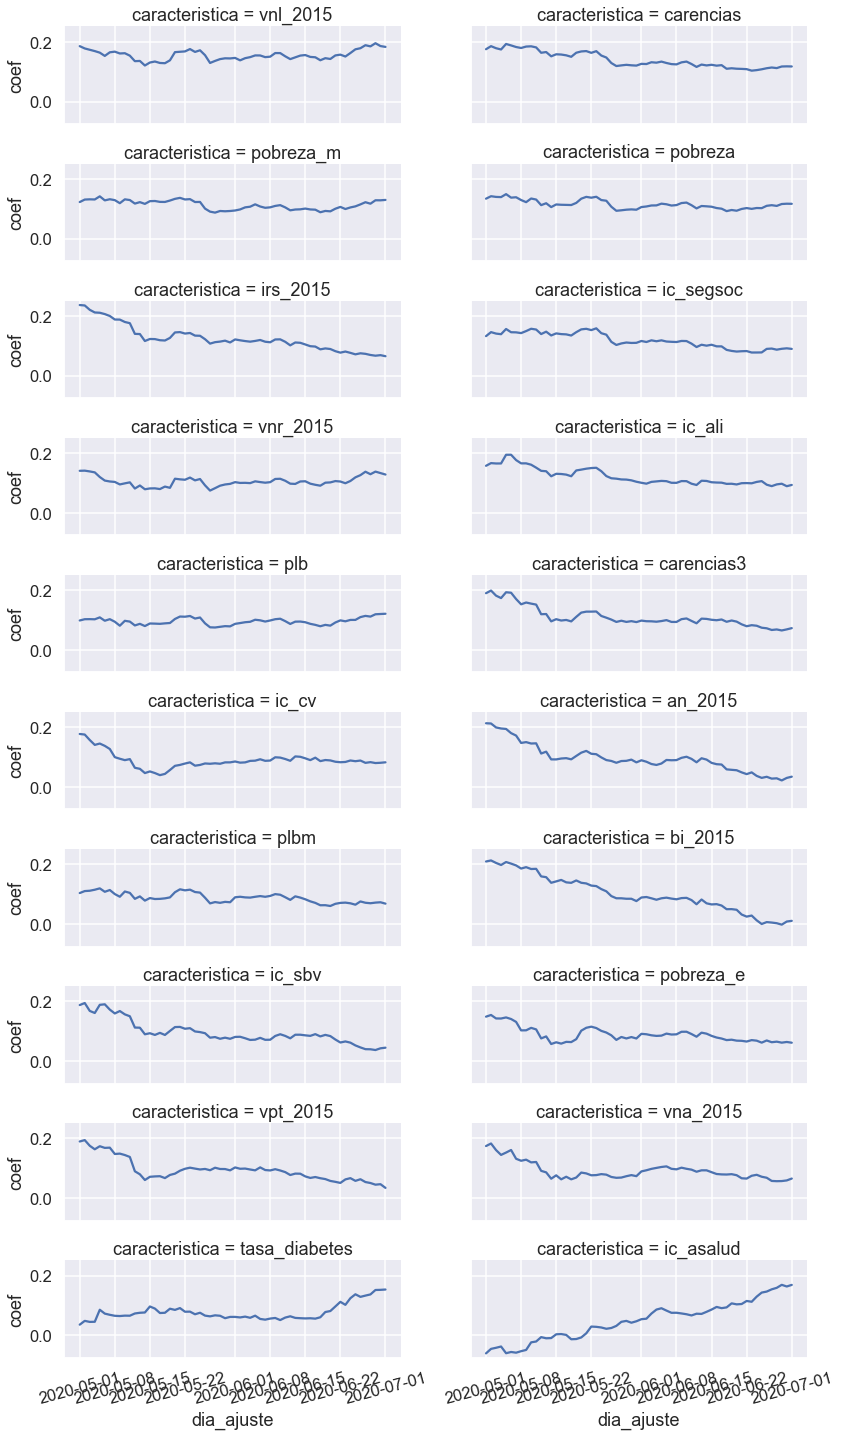

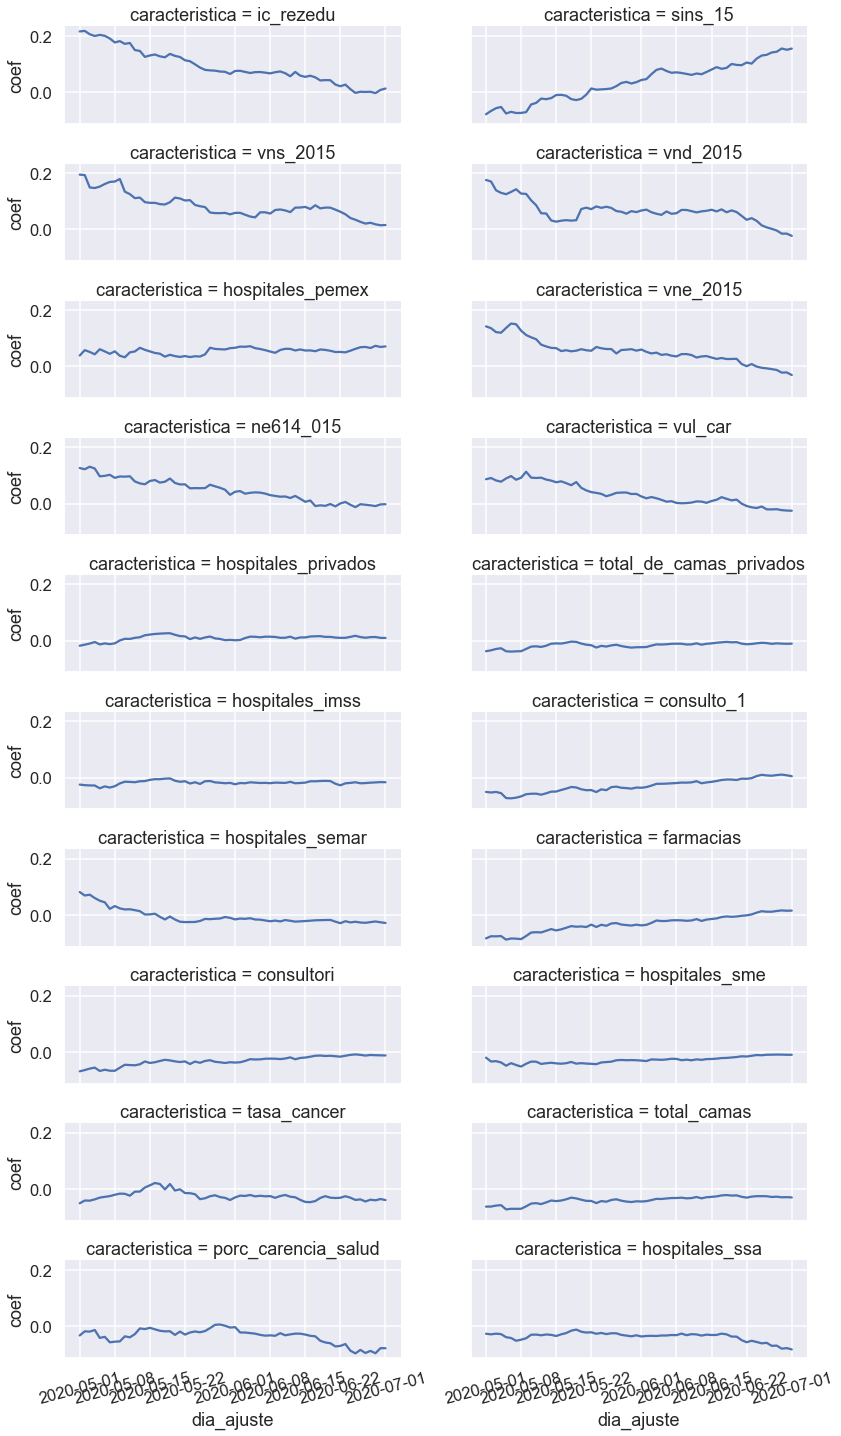

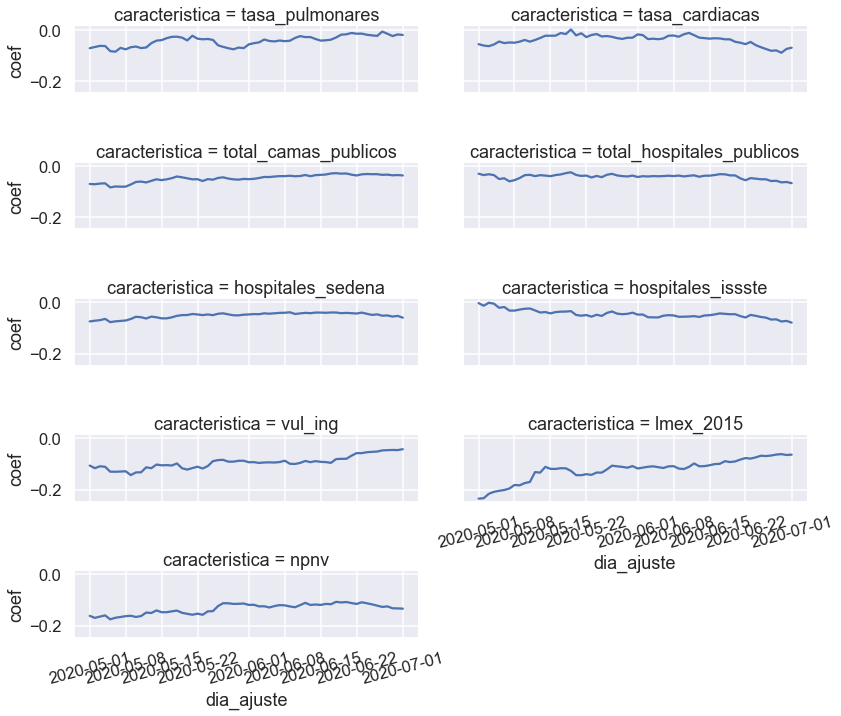

In [ ]:
orden_plots = modelos_pls.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_pls, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[:20])
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.savefig(f'imagenes/coeficientes_ts_pls_{fecha_futuro.strftime("%y%m%d")}_1.png')
plt.show()


g = sns.FacetGrid(modelos_pls, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[20:40])
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.savefig(f'imagenes/coeficientes_ts_pls_{fecha_futuro.strftime("%y%m%d")}_2.png')
plt.show()

g = sns.FacetGrid(modelos_pls, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[40:])
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.savefig(f'imagenes/coeficientes_ts_pls_{fecha_futuro.strftime("%y%m%d")}_3.png')

plt.show()

# sns.pointplot(data=plss[plss.caracteristica == 'ic_rezedu'], x='dia_ajuste', y='coef')

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 1))].copy()
df.drop(columns='geometry', inplace=True)
df.to_csv('vulnerabilidad_200601.csv')

### Comparación municipios urbanos y no urbanos

In [ ]:
modelos_urbanos, serie_urbanos = calcular_vulnerabilidad_urbana('200424', '200715', min_casos=20)

In [ ]:
df = serie_urbanos[((serie_urbanos.modelo == 'PLS_URBANO') | (serie_urbanos.modelo == 'PLS_NO_URBANO')) &
                   (serie_urbanos.dia_ajuste == fecha)]

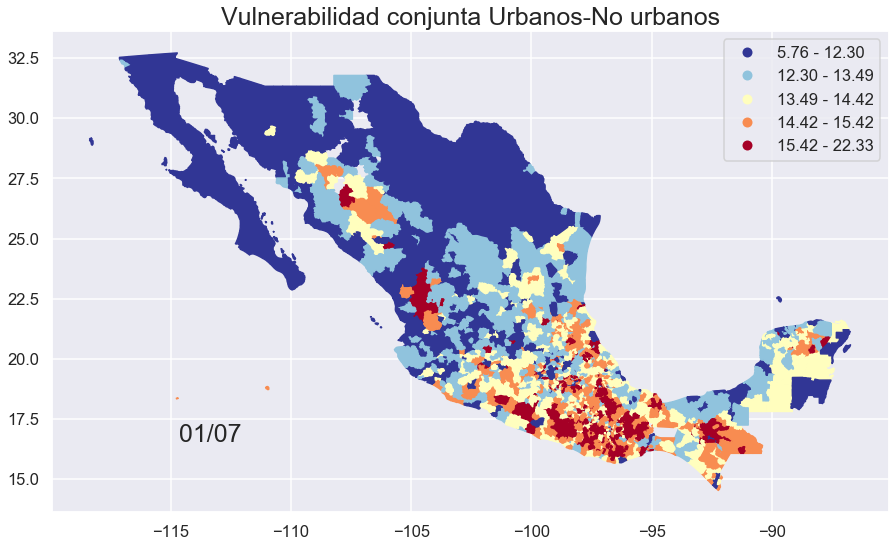

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.valor.notna()].plot(column='valor',
                                edgecolor='face',
                                scheme='Quantiles',
                                k=5,
                                cmap='RdYlBu_r',
                                legend=True,
                                ax=ax)

# remove axis of chart
fig.set_title('Vulnerabilidad conjunta Urbanos-No urbanos', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})

# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=25)

plt.savefig(f'imagenes/vulnerabilidad_urbanos_no_urbanos_{fecha.strftime("%y%m%d")}.png')

In [ ]:
df = serie_urbanos[((serie_urbanos.modelo == 'PLS_URBANO')) &
                   (serie_urbanos.dia_ajuste == fecha)]

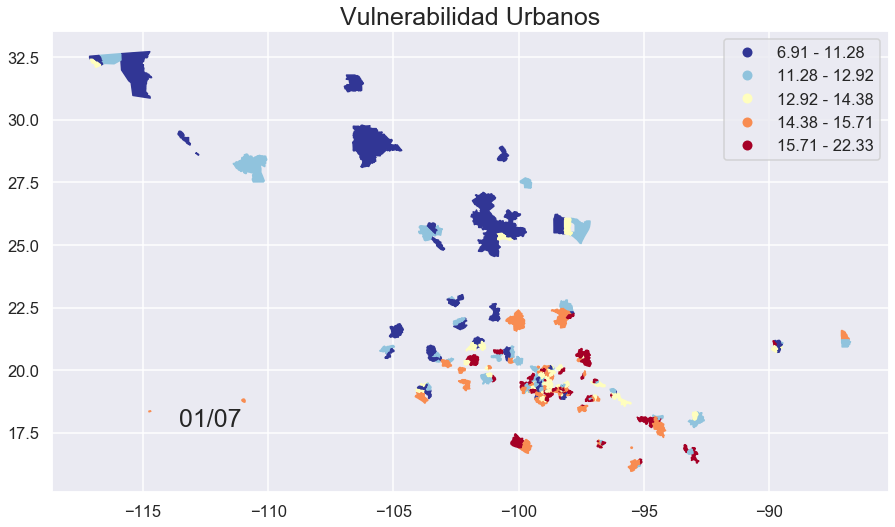

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.valor.notna()].plot(column='valor',
                                scheme='Quantiles',
                                k=5,
                                edgecolor='face',
                                cmap='RdYlBu_r',
                                legend=True,
                                ax=ax)

# remove axis of chart
fig.set_title('Vulnerabilidad Urbanos', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})

# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=25)

plt.savefig(f'imagenes/vulnerabilidad_urbanos_{fecha.strftime("%y%m%d")}.png')
plt.show()

In [ ]:
df = serie_urbanos[((serie_urbanos.modelo == 'PLS_NO_URBANO')) &
                   (serie_urbanos.dia_ajuste == fecha)]

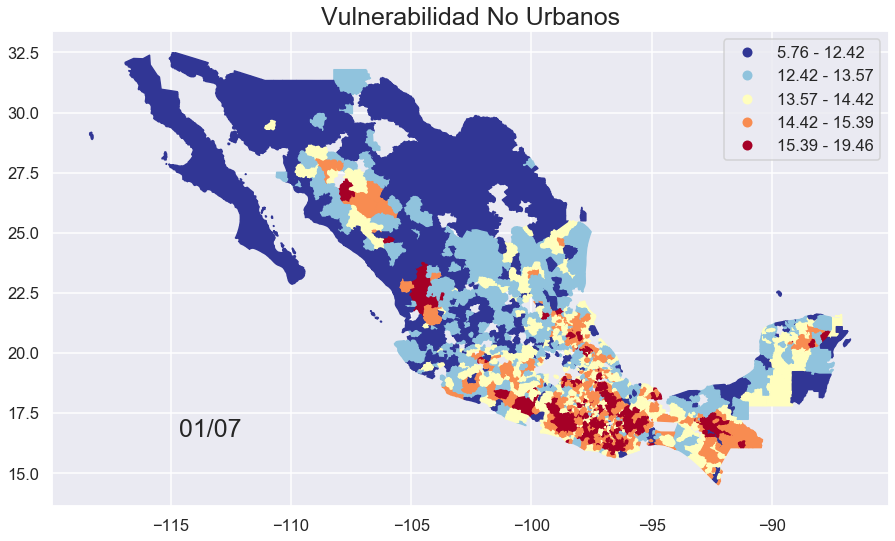

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
fig = df[df.valor.notna()].plot(column='valor',
                                edgecolor='face',
                                scheme='Quantiles',
                                k=5,
                                cmap='RdYlBu_r',
                                legend=True,
                                ax=ax, cax=cax)

# remove axis of chart
fig.set_title('Vulnerabilidad No Urbanos', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})

# position the annotation to the bottom left
fig.annotate(fecha.strftime("%d/%m"),
        xy=(0.2, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=25)

plt.savefig(f'imagenes/vulnerabilidad_no_urbanos_{fecha.strftime("%y%m%d")}.png')
plt.show()

In [ ]:
modelos_urbanos['mediana'] = modelos_urbanos.groupby(['caracteristica', 'modelo'])['coef'].transform('median')


In [ ]:
modelos_urbanos[(modelos_urbanos.modelo == 'PLS_URBANO') & (modelos_urbanos.dia_ajuste == fecha)].head()

caracteristica      coef dia_ajuste      modelo  mediana
6664  tasa_pulmonares  1.11e-02 2020-07-01  PLS_URBANO -0.02   
6665  plbm             1.30e-01 2020-07-01  PLS_URBANO  0.10   
6666  vnd_2015         2.38e-03 2020-07-01  PLS_URBANO  0.03   
6667  pobreza_e        1.17e-01 2020-07-01  PLS_URBANO  0.10   
6668  an_2015          9.94e-02 2020-07-01  PLS_URBANO  0.10

In [ ]:
modelos_urbanos[(modelos_urbanos.modelo == 'PLS_NO_URBANO') & (modelos_urbanos.dia_ajuste == fecha)].head()

caracteristica  coef dia_ajuste         modelo  mediana
6713  tasa_pulmonares  0.02 2020-07-01  PLS_NO_URBANO -0.04   
6714  plbm             0.06 2020-07-01  PLS_NO_URBANO  0.08   
6715  vnd_2015         0.04 2020-07-01  PLS_NO_URBANO  0.06   
6716  pobreza_e        0.06 2020-07-01  PLS_NO_URBANO  0.07   
6717  an_2015          0.05 2020-07-01  PLS_NO_URBANO  0.07

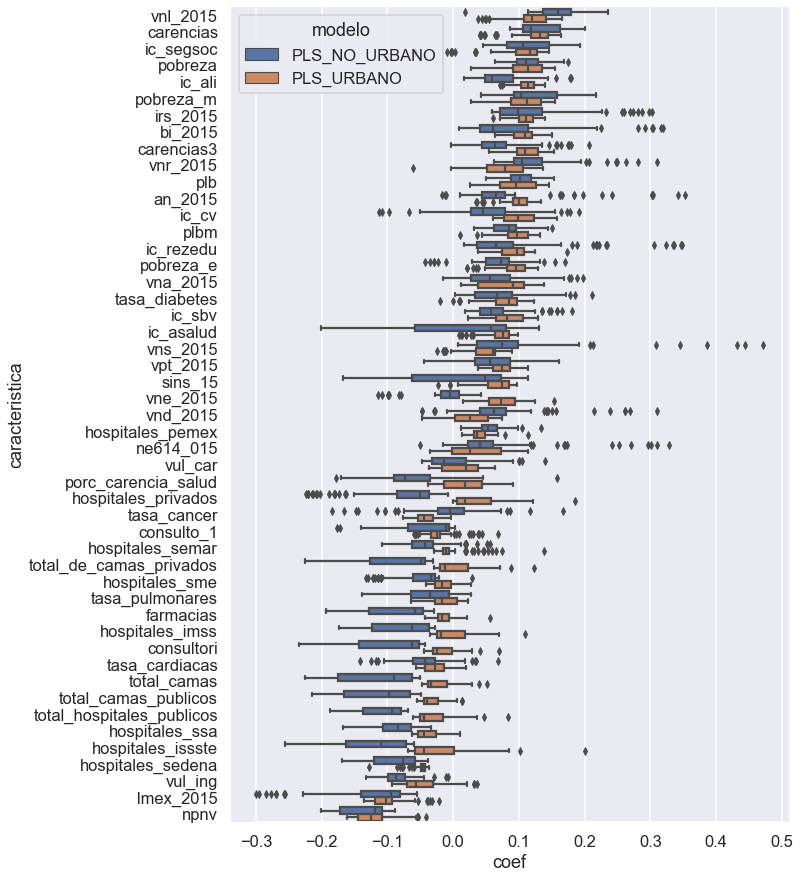

In [ ]:
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(y="caracteristica",
            x="coef",
            data=modelos_urbanos.sort_values(by='mediana', ascending=False),
            hue='modelo')
sns.despine(trim=True, left=True)
plt.savefig(f'imagenes/coeficientes_pls_urbanos_{fecha.strftime("%y%m%d")}.png')
plt.show()

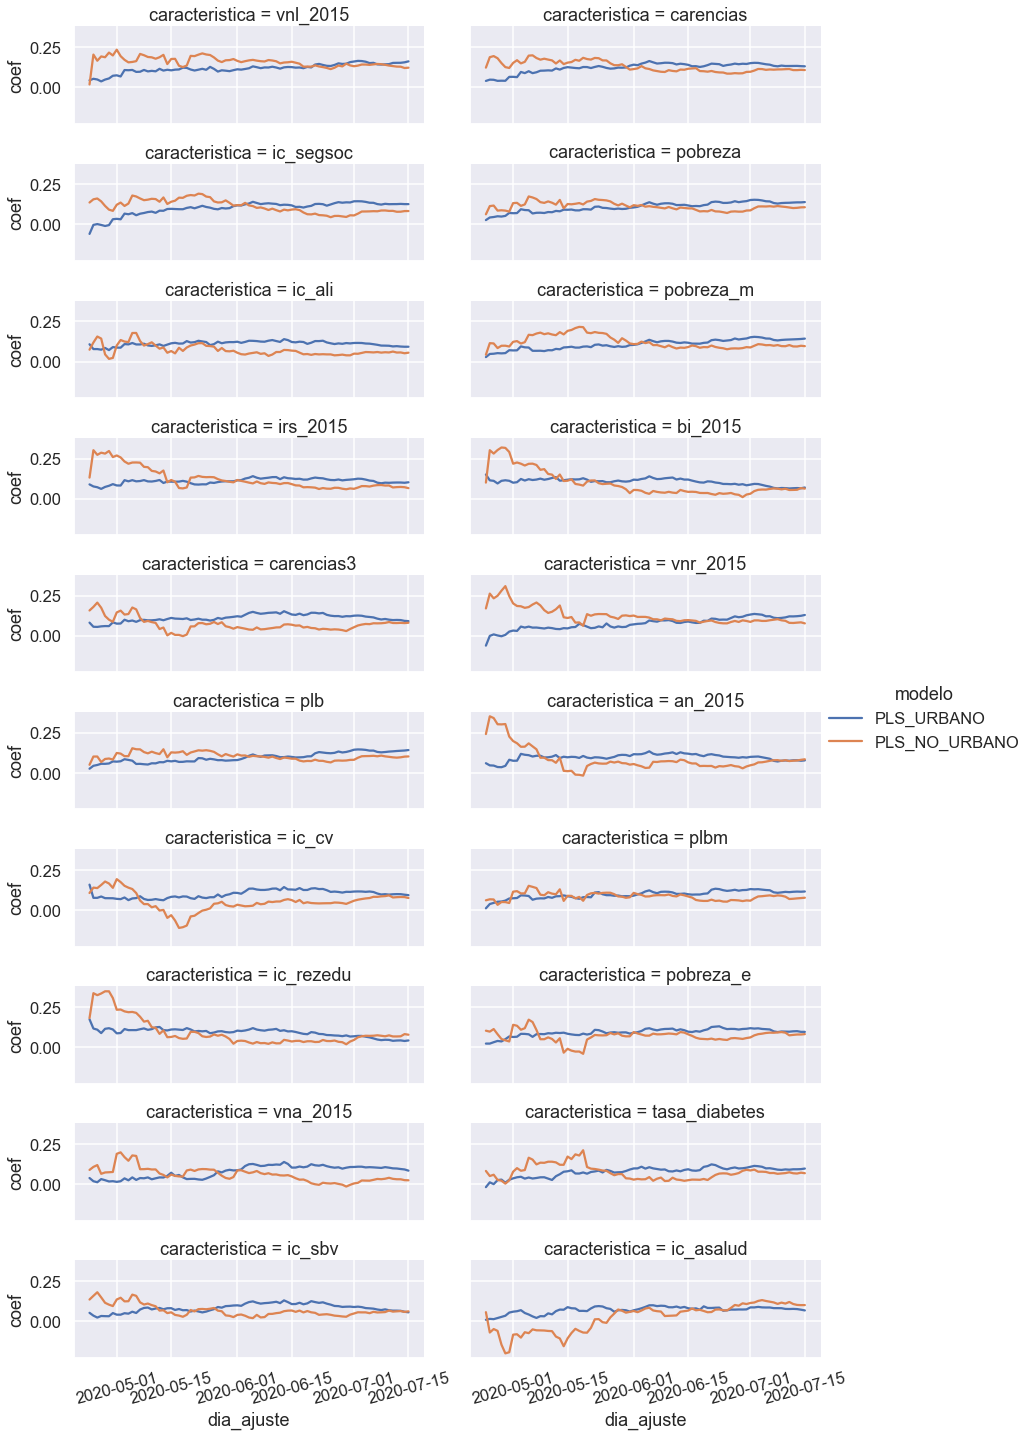

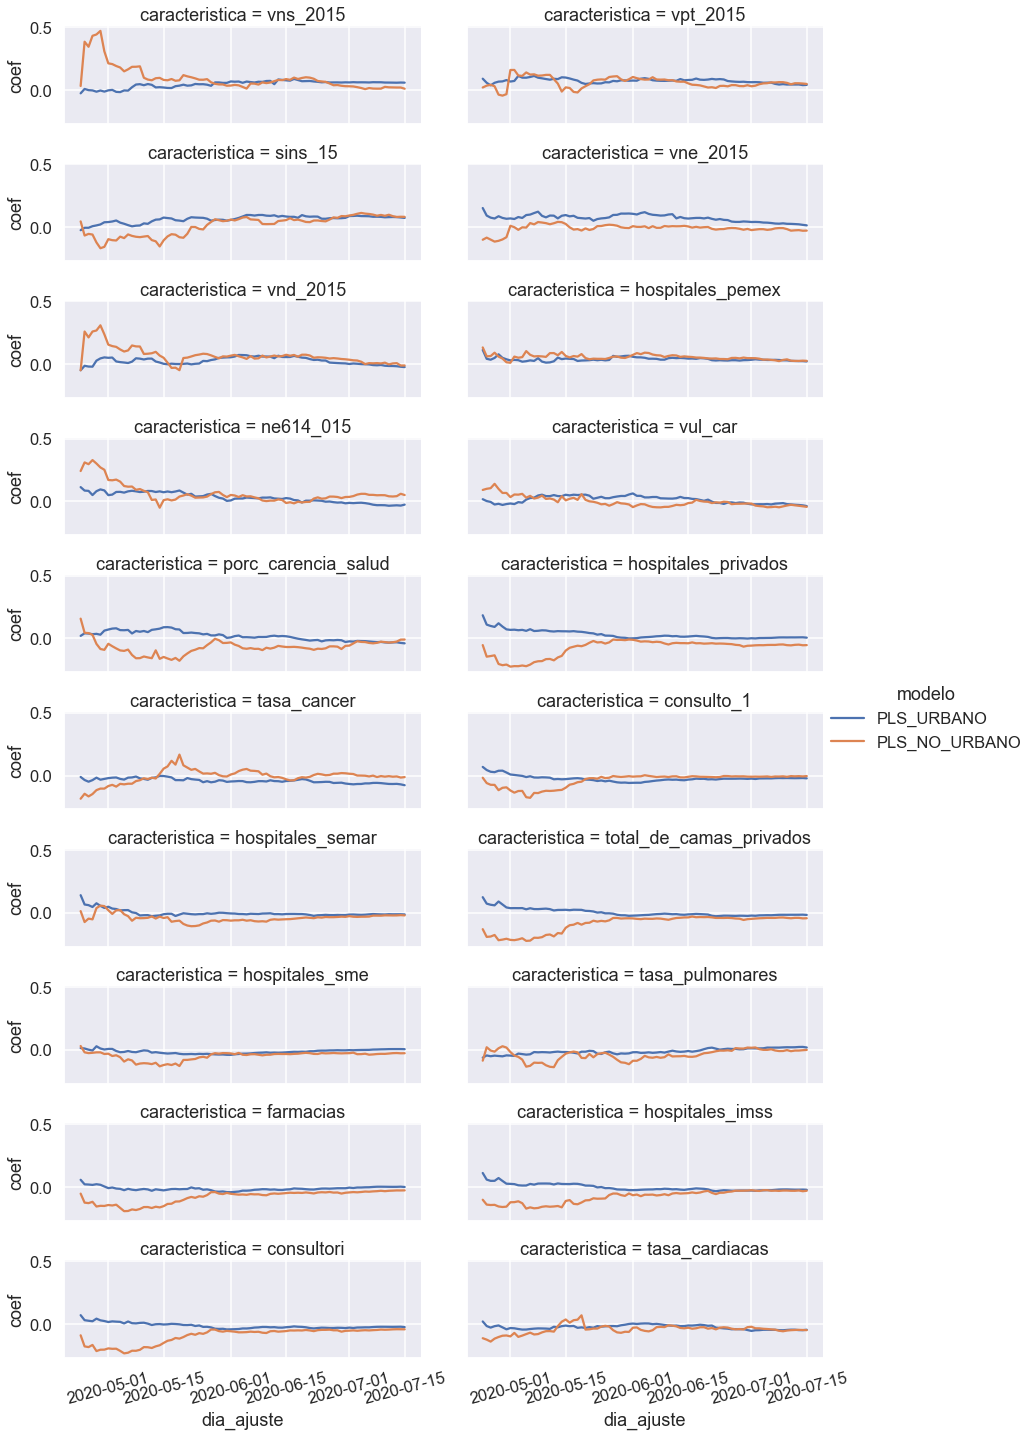

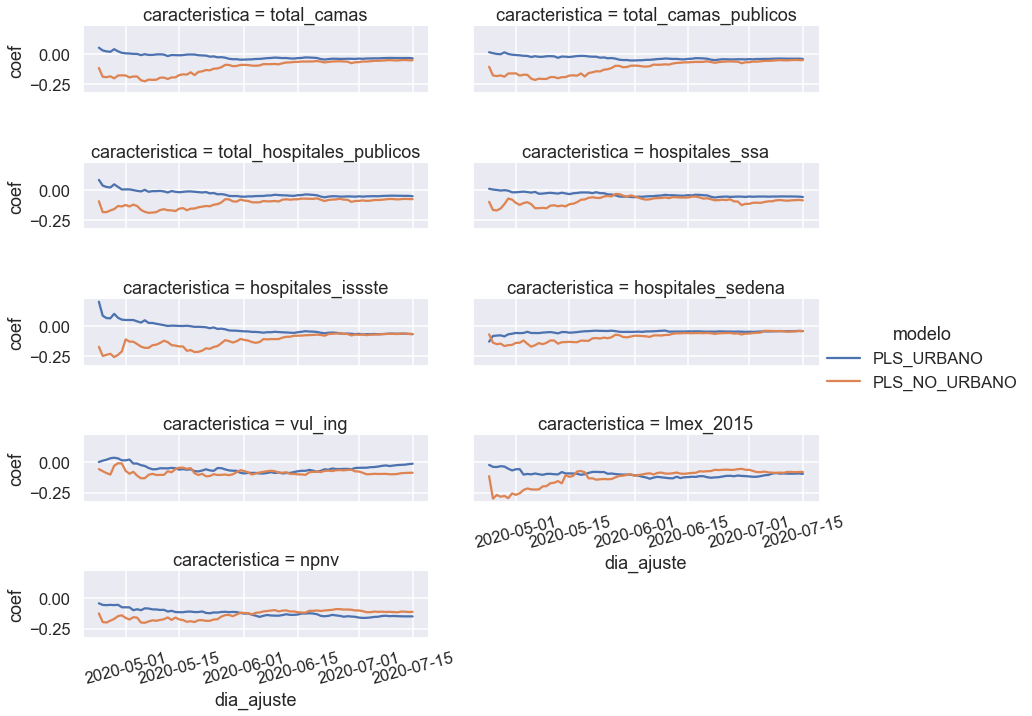

In [ ]:
# ordered_days = tips.day.value_counts().index
orden_plots = modelos_urbanos.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_urbanos, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[:20], hue='modelo', legend_out=True)
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.savefig(f'imagenes/coeficientes_urbanos_ts_pls_{fecha_futuro.strftime("%y%m%d")}_1.png')
plt.show()


g = sns.FacetGrid(modelos_urbanos, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[20:40], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.savefig(f'imagenes/coeficientes_urbanos_ts_pls_{fecha_futuro.strftime("%y%m%d")}_2.png')
plt.show()

g = sns.FacetGrid(modelos_urbanos, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[40:], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.savefig(f'imagenes/coeficientes_urbanos_ts_pls_{fecha_futuro.strftime("%y%m%d")}_3.png')
plt.show()

# sns.pointplot(data=plss[plss.caracteristica == 'ic_rezedu'], x='dia_ajuste', y='coef')

## Comparación Regresión PLS VS Random Forest

### Serie de tiempo de importancia de indicadores

In [ ]:
# ordered_days = tips.day.value_counts().index
modelos_rf = modelos[(modelos.modelo == 'RF')]
orden_plots = modelos_rf.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_rf, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[:20], hue='modelo', legend_out=True)
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()


g = sns.FacetGrid(modelos_rf, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[20:40], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()

g = sns.FacetGrid(modelos_rf, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots[40:], hue='modelo')
g = g.map(sns.lineplot, 'dia_ajuste', "coef").add_legend()
g.set_xticklabels(rotation=15)
plt.show()


### Distibución de vulnerabilidad según Random Forest

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 1)) &
                          (serie_vulnerabilidad.modelo == 'RF')].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['valor'].transform('median')
sns.boxplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', palette='Greys_r')
sns.swarmplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

### Correlación entre letalidad y vulnerabilidad RF

In [ ]:
reg_df = df[(df.defunciones > 5)]
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
reg_df = df[(df.defunciones > 5) & df.valor.notna()]
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.969


In [ ]:
modelos[(modelos.modelo == 'RF') & 
        (modelos.dia_ajuste == datetime.datetime(2020, 6, 1))].sort_values(by='coef',
                                                                            ascending=False).reset_index(drop=True)

### Correlación entre vulnerabilidad RF y letalidad en el futuro

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 1)) &
                          (serie_vulnerabilidad.modelo == 'RF')]
X_df = df
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 15)) &
                          (serie_vulnerabilidad.modelo == 'RF')]
Y_df = df[df.defunciones > 5]

In [ ]:
datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor']],
                                                on='CLAVE_MUNICIPIO_RES')

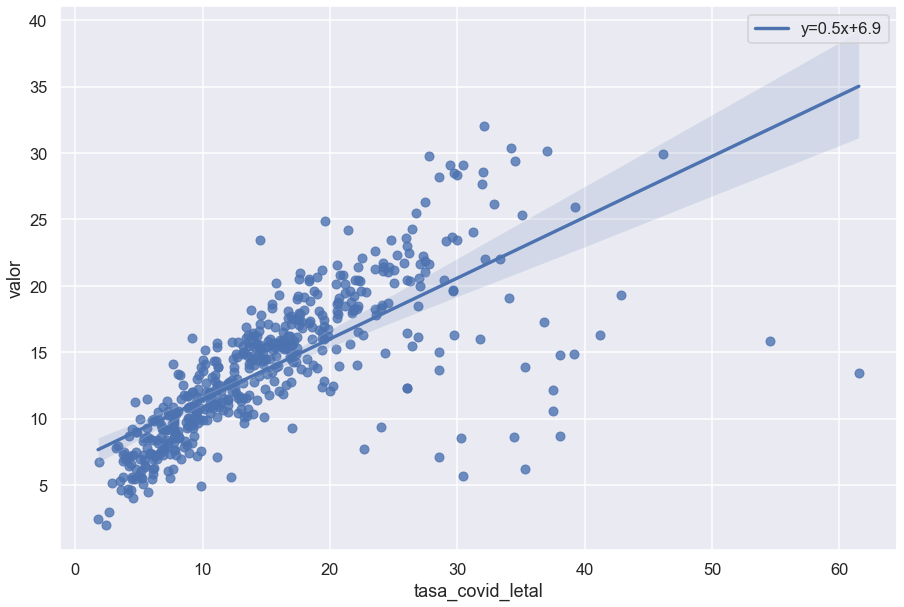

In [ ]:
reg_df = datos_prueba
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.830


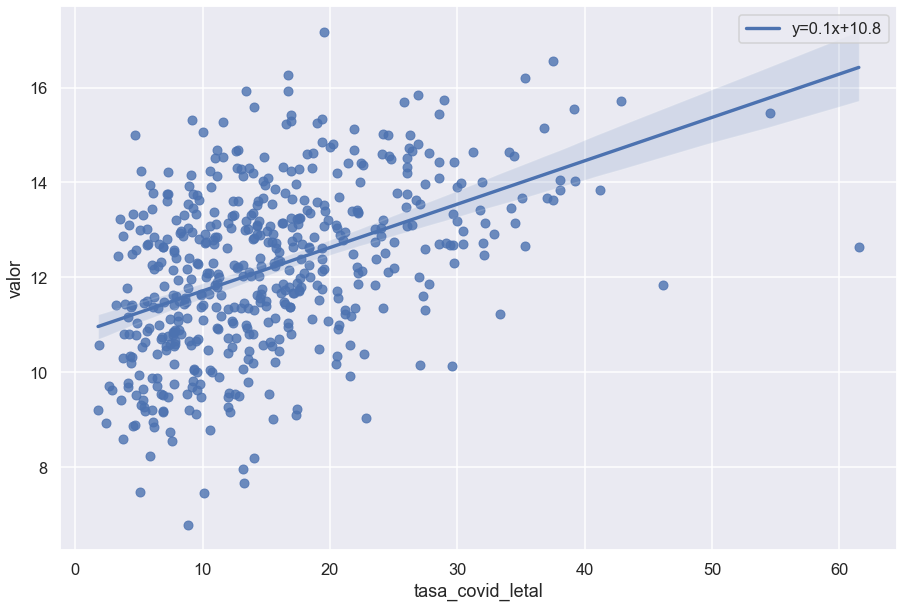

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha) &
                          (serie_vulnerabilidad.modelo == 'PLS')]
X_df = df
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == fecha_futuro) &
                          (serie_vulnerabilidad.modelo == 'PLS')]
Y_df = df[df.defunciones > 5]

datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor']],
                                                on='CLAVE_MUNICIPIO_RES')

reg_df = datos_prueba
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.savefig('imagenes/correlacion_pls_test_200715.png')
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

Correlación de Spearman: 0.460


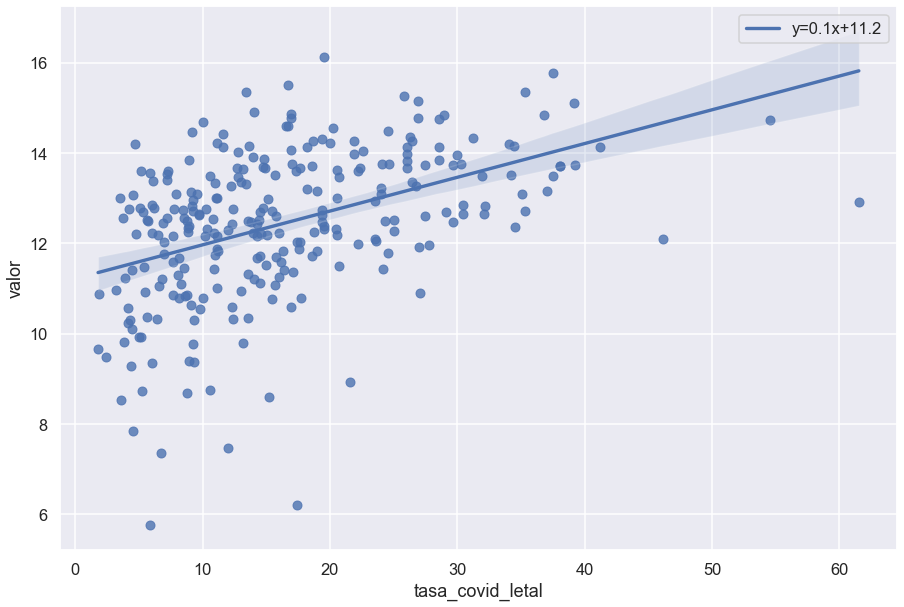

Correlación de Spearman: 0.482


In [ ]:
df = serie_urbanos[(serie_urbanos.dia_ajuste == fecha) &
                          (serie_urbanos.modelo == 'PLS_NO_URBANO')]
X_df = df
df = serie_urbanos[(serie_urbanos.dia_ajuste == fecha_futuro) &
                          (serie_urbanos.modelo == 'PLS_NO_URBANO')]
Y_df = df[df.defunciones > 5]

datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor']],
                                                on='CLAVE_MUNICIPIO_RES')

reg_df = datos_prueba
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

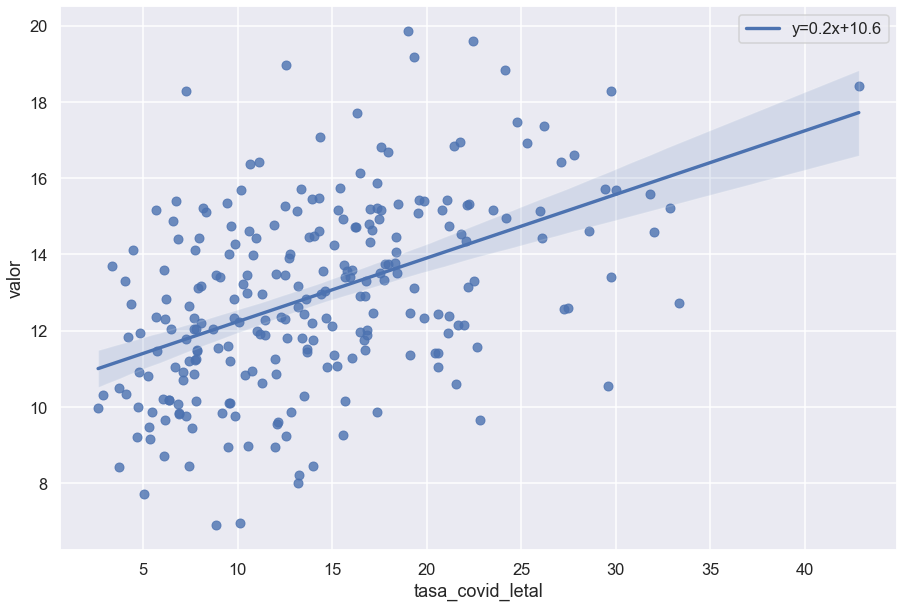

Correlación de Spearman: 0.478


In [ ]:
df = serie_urbanos[(serie_urbanos.dia_ajuste == fecha) &
                          (serie_urbanos.modelo == 'PLS_URBANO')]
X_df = df
df = serie_urbanos[(serie_urbanos.dia_ajuste == fecha_futuro) &
                          (serie_urbanos.modelo == 'PLS_URBANO')]
Y_df = df[df.defunciones > 5]

datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor']],
                                                on='CLAVE_MUNICIPIO_RES')

reg_df = datos_prueba
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

¿Qué tan bien califica los municipios que no estuvieron en el ajuste del RF comparando con el futuro? Es decir los que no tenían más de 20 casos en el ajuste.

### Evaluación con municipios fuera del ajuste en el futuro 

In [ ]:
ajuste_df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 1))]

ajuste_df = ajuste_df[['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES', 'modelo', 'valor']]
prueba_df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 15))
                    & (serie_vulnerabilidad.defunciones > 5)]

prueba_df = prueba_df[~prueba_df.CLAVE_MUNICIPIO_RES.isin(ajuste_df.CLAVE_MUNICIPIO_RES.drop_duplicates())]

X_df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 7, 1))]
Y_df = prueba_df
datos_prueba = Y_df[['CLAVE_MUNICIPIO_RES',
                     'defunciones', 'conteo', 'tasa_covid_letal']].merge(X_df[['CLAVE_MUNICIPIO_RES',
                                                      'valor', 'modelo']],
                                                on='CLAVE_MUNICIPIO_RES', how='left')

In [ ]:
reg_df = datos_prueba[datos_prueba.modelo == 'PLS']
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

In [ ]:
reg_df = datos_prueba[datos_prueba.modelo == 'RF']
slope, intercept, r_value, p_value, std_err = linregress(reg_df['tasa_covid_letal'], reg_df['valor'])

f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=reg_df, x='tasa_covid_letal', y='valor',
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [ ]:
corr, _ = spearmanr(reg_df.tasa_covid_letal, reg_df.valor)
print('Correlación de Spearman: %.3f' % corr)

# Conclusiones

Presentamos una herrramienta para identificar municipios vulnerables a los efectos de la pandemia de COVID-19 mediante un índice que sintetiza la relación entre letalidad de COVID-19 y los indicadores de pobreza y rezago social de CONEVAL, el número unidades de salud (privadas y públicas), y estadísticas de mortalidad de INEGI. Este índice sirve como herramienta de inferencia sobre la letalidad observada en los municipios de México. 

Al utilizar como proxy la letalidad consideramos que el índice cuantifica al menos parcialmente la vulnerabilidad de un municipio a la epidemia, en el sentido de que la población de un municipio con alta vulnerabilidad es suceptible a tener una incidencia mayor de casos letales. A diferencia de otros índices de vulnerabilidad que sólo se pueden actualizar conforme se actualizan los datos de indicadores, este índice se puede actualizar siempre que existan datos nuevos sobre los indicadores independientes o se actualicen los datos sobre casos de COVID-19. En este último sentido sirve para monitorear si la relación entre la letalidad y las características cambia. Esto cambio pueden ser debido a intervenciones del gobierno, a nuevos patrones de comportamiento de la sociedad o a cambios en la evolución de la epidemia, y en este sentido el índice no nos explica la causa, sirve para informarnos sobre estos cambios. Consideramos que este seguimiento tiene aplicaciones como detectar si una intervención tuvo resultados para mejorar la respuesta a los casos en municipios con ciertas características. Esto nos permite adaptar el índice a nuevas condiciones de la epidemia, en particular, si la evidencia apunta hacia nuevos municipios como los más vulnerables. También sirve para detectar si cambia la relación entre las características de los municipios y la letalidad, por ejemplo, si con nuevos datos cambian las características que resultan con el mayor coeficiente. Un caso particular que revisamos fue el del índice de rezago educativo, en los primeros días del periódo que analizamos el rezago educativo tiene preponderancia, pero en días posteriores los indicadores relacionados con pobreza, vivienda y cobertura de salud cobran mayor relevancia. Quedan investigar por qué sucede esto. A partir de estas observaciones también surgen preguntas sobre cómo segmentar los datos, por ejemplo, para los municipios urbanos con alta letalidad por COVID-19 es probable que la relación entre sus características y la letalidad sea diferente a la relación que existe en los casos de municipios no urbano con alta letalidad. 

La calidad de este índice depende por supuesto de la calidad de los datos de entrada, y del espectro de indicadores que utilicemos. Datos de comorbilidades, podrían mejorar la infrmación que nos da el índice, así como otros datos económicos y sociales y de disponibilidad de camas por ejemplo.

Esperamos que este trabajo pueda aprovecharse para fortalecer la respuesta para identificar y proteger a poblaciones vulnerables ante la amenaza de ésta pandemia.


### Últimas consideraciones


### Cierre
* Visualización: https://coronavirus.conacyt.mx/visualizaciones/nacionales/
* Código: https://github.com/rausial/covid19_vulnerabilidad_mex

![Visualización índice de vulnerabilidad](imagenes/vulnerabilidad_micrositio_conacyt.png)


# Pendientes

Lista de pendientes:

* Calcular varianza de vulnerabilidad municipal de entidades
* Usar datos de mortalidad de R_t
* Calcular varianza de coeficientes con selección aleatoria de municipios
* Validación cruzada temporal
* Probar vulnerabilidad dividiendo por tamaño de población (100k?)
* Análisis urbanos VS no urbanos
* Probar desempeño con más componentes PLS
* Calcular con últimos datos publicados las series de tiempo
* Analizar cambio de coeficientes en ventanas mensuales
* Agregar porcentaje de casos UCI a Y, y analizar predicción de letalidad
* Serie de tiempo de vulnerabilidad promedio por entidad
* Visualización: colorear indicadores por categoría (infraestructura de salud, rezago social, pobreza, salud)
* Profundizar análisis de resultados PLS
* Covarianza temporal de la letalidad (covarianza entre pasado y futuro)
* Rankeo mensuale de importancia de indicadores
* Hacer series de tiempo coeficientes, pero en vez usar el valor usar su posición (rank)



In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()